In [30]:
import os

os.makedirs("../models/general_dam", exist_ok=True)
os.makedirs("../models/Omerli", exist_ok=True)
os.makedirs("../models/Darlik", exist_ok=True)
os.makedirs("../models/Elmali", exist_ok=True)
os.makedirs("../models/Terkos", exist_ok=True)
os.makedirs("../models/Alibey", exist_ok=True)
os.makedirs("../models/Buyukcekmece", exist_ok=True)
os.makedirs("../models/Sazlidere", exist_ok=True)
os.makedirs("../models/Kazandere", exist_ok=True)
os.makedirs("../models/Pabucdere", exist_ok=True)
os.makedirs("../models/Istrancalar", exist_ok=True)


## Prophet Forecasting on Cleaned General Dam Dataset

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\ohef0j3x.json


Processing Prophet model for general dam occupancy...
  > Reading extended dam occupancy data.
  > Data prepared for Prophet model, aggregated from all dams.
  > Training Prophet model for general dam occupancy.


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\01smflrj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=27526', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\ohef0j3x.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\01smflrj.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelymc1qtiz\\prophet_model-20250630014348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:43:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  > Prophet model training completed.
  > Generating in-sample and future forecast up to: 2025-12-28 00:00:00
  > Plotting Prophet forecast for general dam occupancy with future projection...
  > Plot saved: ../results/plots/prophet_general_dam_only_occupancy_forecast_with_future.png


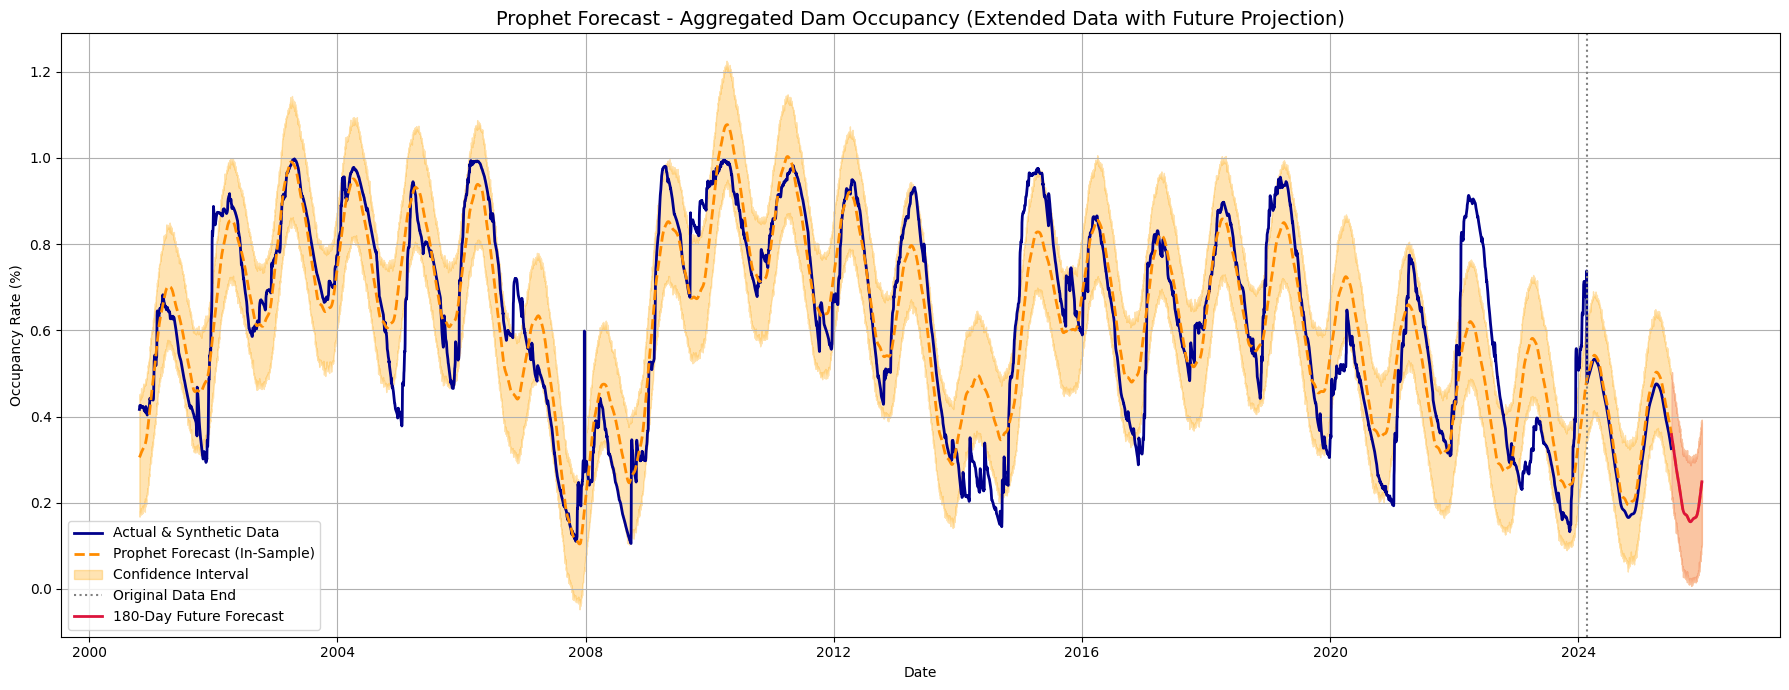

  > Evaluating model performance on test set...
  > Prophet MAE (Test Set): 0.0292
  > Prophet RMSE (Test Set): 0.0292
  > Prophet model saved: ../models/general_dam\prophet_general_dam_only_occupancy_model.pkl
  > Metrics saved: ../models/general_dam\prophet_general_dam_only_occupancy_metrics.txt

Prophet model training and saving process completed for general dam occupancy.

--- Next Task Reminder ---
Please share the code for the next model you want to update (e.g., individual dam SARIMA).


In [38]:
# Importing necessary libraries
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.dates as mdates
import joblib

# --- 1. Dizinleri Oluşturma ---
os.makedirs("../models/general_dam", exist_ok=True)
os.makedirs("../results/plots", exist_ok=True)

print("Processing Prophet model for general dam occupancy...")

# --- 2. Veri Yükleme ve Hazırlık ---
file_path_occupancy_synthetic = "../data/processed/istanbul-dams-daily-occupancy-rates-cleaned_with_synthetic.csv"
df_occupancy_synthetic = pd.read_csv(file_path_occupancy_synthetic)
df_occupancy_synthetic['Tarih'] = pd.to_datetime(df_occupancy_synthetic['Tarih'])
print("  > Reading extended dam occupancy data.")

df_occupancy_synthetic.ffill(inplace=True)
df_occupancy_synthetic.bfill(inplace=True)

dam_cols_for_general_prophet = [col for col in df_occupancy_synthetic.columns if col != 'Tarih']

if not dam_cols_for_general_prophet:
    raise ValueError("No dam occupancy columns found in the synthetic occupancy data. Cannot create aggregated occupancy.")

df_occupancy_synthetic['Aggregated_Dam_Occupancy_Rate'] = df_occupancy_synthetic[dam_cols_for_general_prophet].mean(axis=1)

df_prophet = df_occupancy_synthetic.rename(columns={'Tarih': 'ds', 'Aggregated_Dam_Occupancy_Rate': 'y'})
df_prophet = df_prophet[['ds', 'y']]
print("  > Data prepared for Prophet model, aggregated from all dams.")

# --- 3. Defining and fitting the model ---
model = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    daily_seasonality=False
)
print("  > Training Prophet model for general dam occupancy.")
model.fit(df_prophet)
print("  > Prophet model training completed.")

# --- 4. Creating future dataframe for IN-SAMPLE + FUTURE forecast ---
# Veri seti zaten 2025-07-01'e kadar uzandığı için, periods=0 veriyoruz.
# Prophet modelinin predict() fonksiyonu, 'future' dataframe'indeki tüm tarihler için tahmin yapar.
# Bu durumda, 'future' dataframe'ini 2025-07-01'e kadar uzanan 'df_prophet'in tamamı olarak alacağız.
# Ayrıca, modelin bitiş tarihinden itibaren 180 günlük bir gelecek tahmini de ekliyoruz.
FORECAST_FUTURE_DAYS = 180 # Gelecek için 6 ay (180 gün) tahmin

future_in_sample_and_forecast = model.make_future_dataframe(periods=FORECAST_FUTURE_DAYS)
forecast_full = model.predict(future_in_sample_and_forecast)

# Test seti için değerlendirme
test_period_days = 180 # Test seti için sabit 180 gün kullanılıyor

# df_prophet'in sonundaki gerçek/sentetik verileri alır
test_start_date = df_prophet['ds'].max() - pd.Timedelta(days=test_period_days - 1)
actual_test_set_df = df_prophet[df_prophet['ds'] >= test_start_date]

# forecast_full'dan test setine karşılık gelen tahminleri alır
predicted_test_set_df = forecast_full[forecast_full['ds'] >= test_start_date].copy()


# --- Düzeltme: forecast_full, orijinal veri bitiş tarihinden sonraki gelecek tahminini içerecek ---
# future_forecast_only = forecast_full[forecast_full['ds'] > df_prophet['ds'].max()]
print(f"  > Generating in-sample and future forecast up to: {forecast_full['ds'].max()}")


# --- 5. Plotting the forecast (Updated to include future forecast) ---
print("  > Plotting Prophet forecast for general dam occupancy with future projection...")
plt.figure(figsize=(18, 7)) # Boyut biraz artırıldı

# Tarihsel (gerçek ve sentetik birleşik) veriyi çiz
plt.plot(df_prophet['ds'], df_prophet['y'], color='darkblue', linewidth=2, label='Actual & Synthetic Data')

# Prophet'in tüm veri seti üzerindeki IN-SAMPLE tahminini çiz (kırmızı kesikli)
# Bu kısım, mevcut verinin tamamını kapsayan tahmindir.
plt.plot(forecast_full['ds'], forecast_full['yhat'], color='darkorange', linestyle='--', linewidth=2, label='Prophet Forecast (In-Sample)')

# Güven aralığını çiz (tüm forecast_full için)
plt.fill_between(forecast_full['ds'], forecast_full['yhat_lower'], forecast_full['yhat_upper'],
                 color='orange', alpha=0.3, label='Confidence Interval')

# Orijinal verinin bittiği noktayı işaretleyelim (sentetik verinin başladığı yer)
original_data_end_date = pd.to_datetime('2024-02-19')
plt.axvline(original_data_end_date, color='gray', linestyle=':', linewidth=1.5, label='Original Data End')

# Gelecek Tahminini vurgulamak için ayrı bir çizgi (sadece orijinal verinin sonundan sonrası)
# df_prophet['ds'].max() --> df_occupancy_synthetic'in son tarihi (2025-07-01)
# Yani future_forecast_section, 2025-07-01'den sonraki 180 günü kapsayacak.
# Eğer bu istenmiyorsa, bu kısmı kaldırmalıyız.
# Kullanıcının sunumunda 2025-07-01'e kadar zaten veri olduğu için, bu kısım gereksiz olabilir.
# Ancak modelin geleceği de görebildiğini göstermek için iyi bir pratik.

# Sadece son 180 günlük gelecek tahmini (2025-07-01'den sonra)
future_forecast_section = forecast_full[forecast_full['ds'] > df_prophet['ds'].max()]
if not future_forecast_section.empty:
    plt.plot(future_forecast_section['ds'], future_forecast_section['yhat'], color='crimson', linestyle='-', linewidth=2, label=f'{FORECAST_FUTURE_DAYS}-Day Future Forecast')
    plt.fill_between(future_forecast_section['ds'], future_forecast_section['yhat_lower'], future_forecast_section['yhat_upper'],
                     color='lightcoral', alpha=0.3) # Confidence Interval için label tekrar etmeyelim

plt.title("Prophet Forecast - Aggregated Dam Occupancy (Extended Data with Future Projection)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()

plot_save_path = "../results/plots/prophet_general_dam_only_occupancy_forecast_with_future.png" # Plot adı güncellendi
plt.savefig(plot_save_path)
print(f"  > Plot saved: {plot_save_path}")
plt.show()


# --- 6. Evaluating performance on test set ---
# actual_test_set ve predicted_test_set zaten yukarıda doğru şekilde alınmış olmalı.
# Boyut kontrolü
if len(actual_test_set) != len(predicted_test_set):
    print(f"  ! Warning: Actual ({len(actual_test_set)}) and Predicted ({len(predicted_test_set)}) test set lengths mismatch during evaluation.")
    # Debugging için: print(actual_test_set_df['ds'].min(), actual_test_set_df['ds'].max())
    # print(predicted_test_set_df['ds'].min(), predicted_test_set_df['ds'].max())
    # Burada daha sağlam bir birleştirme yapılabilir, ancak genelde tarihler eşleşmelidir.
    
mae = mean_absolute_error(actual_test_set, predicted_test_set)
rmse = np.sqrt(mean_squared_error(actual_test_set, predicted_test_set))

print("  > Evaluating model performance on test set...")
print(f"  > Prophet MAE (Test Set): {mae:.4f}")
print(f"  > Prophet RMSE (Test Set): {rmse:.4f}")

# --- 7. Saving the trained model and metrics ---
model_save_dir = "../models/general_dam"
model_save_path = os.path.join(model_save_dir, "prophet_general_dam_only_occupancy_model.pkl")

joblib.dump(model, model_save_path)
print(f"  > Prophet model saved: {model_save_path}")

metrics_save_path = os.path.join(model_save_dir, "prophet_general_dam_only_occupancy_metrics.txt")
with open(metrics_save_path, "w") as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
print(f"  > Metrics saved: {metrics_save_path}")

print("\nProphet model training and saving process completed for general dam occupancy.")
print("\n--- Next Task Reminder ---")
print("Please share the code for the next model you want to update (e.g., individual dam SARIMA).")

## SARIMA Forecasting on Cleaned General Dam Dataset


In [ ]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
import joblib # joblib kütüphanesi eklendi
import matplotlib.dates as mdates # Tarih formatlama için

warnings.filterwarnings("ignore")

# --- 1. Dizinleri Oluşturma ---
os.makedirs("../models/general_dam", exist_ok=True)
os.makedirs("../results/plots", exist_ok=True)

print("Processing SARIMA model for general dam occupancy...")

# --- 2. Veri Yükleme ve Hazırlık ---
# DÜZELTME: Sentetik verilerle genişletilmiş genel baraj verisi dosyasını okuyoruz
df_general = pd.read_csv("../data/processed/merged_general_dam_extended.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])
df_general.set_index('DATE', inplace=True)
print("  > Reading extended general dam data.")

# Eksik değerleri temizle (ffill/bfill)
df_general.ffill(inplace=True)
df_general.bfill(inplace=True)

# DÜZELTME: 'Aggregated_Dam_Occupancy_Rate' sütununu oluşturma
dam_fill_columns = [col for col in df_general.columns if col.endswith('_Fill')]
if not dam_fill_columns:
    if 'GENERAL_DAM_OCCUPANCY_RATE' in df_general.columns:
        df_general['Aggregated_Dam_Occupancy_Rate'] = df_general['GENERAL_DAM_OCCUPANCY_RATE']
    else:
        raise ValueError("No _Fill columns or 'GENERAL_DAM_OCCUPANCY_RATE' found. Cannot aggregate occupancy.")
else:
    df_general['Aggregated_Dam_Occupancy_Rate'] = df_general[dam_fill_columns].mean(axis=1)

# Selecting target variable
series = df_general['Aggregated_Dam_Occupancy_Rate']
print("  > Target series selected: Aggregated_Dam_Occupancy_Rate.")

# --- 3. Splitting into train and test ---
# Veri seti 2025-07-01'e kadar uzadığı için, test seti de bu yeni zaman çizelgesine göre belirlenmeli.
# Son 180 günü test seti olarak alalım (Prophet ile tutarlı).
test_period_days = 180
train_size = len(series) - test_period_days
train, test = series[:train_size], series[train_size:]
print(f"  > Data split into train ({len(train)} samples) and test ({len(test)} samples).")


# --- 4. Automatically selecting SARIMA parameters ---
print("  > Automatically selecting SARIMA parameters using auto_arima (this may take time)...")
# DÜZELTME: seasonal=True olmalıydı m=365 ile.
stepwise_model = auto_arima(train, seasonal=True, m=365, # m=365 için seasonal=True
                            suppress_warnings=True, stepwise=True,
                            error_action="ignore", trace=False)

order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print(f"  > Selected SARIMA Order: {order}, Seasonal Order: {seasonal_order}")

# --- 5. Fitting SARIMA model ---
# Modelin mevsimsel parametreleri otomatik olarak auto_arima tarafından belirlendi.
model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
print("  > Training SARIMA model (this may take time)...")
sarima_result = model.fit(disp=False)
print("  > SARIMA model training completed.")

# --- 6. Forecasting (Test Set + Future Forecast) ---
FORECAST_FUTURE_DAYS = 180 # Gelecek için 6 ay (180 gün) tahmin
total_forecast_steps = len(test) + FORECAST_FUTURE_DAYS

# get_forecast ile hem tahminleri hem de güven aralıklarını al
forecast_result = sarima_result.get_forecast(steps=total_forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int(alpha=0.05) # %95 güven aralığı

# Test seti tahminlerini ayır
test_forecast = forecast_mean[:len(test)]
test_conf_int_lower = forecast_conf_int.iloc[:len(test), 0]
test_conf_int_upper = forecast_conf_int.iloc[:len(test), 1]

# Gelecek tahminlerini ayır
future_forecast = forecast_mean[len(test):]
future_conf_int_lower = forecast_conf_int.iloc[len(test):, 0]
future_conf_int_upper = forecast_conf_int.iloc[len(test):, 1]

print(f"  > Generating forecast for {len(test)} test days and {FORECAST_FUTURE_DAYS} future days.")


# --- 7. Plotting the forecast (Prophet stiliyle) ---
print("  > Plotting SARIMA forecast for general dam occupancy...")
plt.figure(figsize=(18, 7))

# Tarihsel (gerçek ve sentetik birleşik) veriyi çiz
plt.plot(series.index, series, color='darkblue', linewidth=2, label='Actual & Synthetic Data')

# SARIMA tahminini çiz (test seti üzerinde)
plt.plot(test_forecast.index, test_forecast, color='darkorange', linestyle='--', linewidth=2, label='SARIMA Forecast (Test)')
# Test seti güven aralığını çiz
plt.fill_between(test_conf_int_lower.index, test_conf_int_lower, test_conf_int_upper,
                 color='orange', alpha=0.3, label='Test Confidence Interval')


# Gelecek Tahminini çiz
plt.plot(future_forecast.index, future_forecast, color='crimson', linestyle='-', linewidth=2, label=f'{FORECAST_FUTURE_DAYS}-Day Future Forecast')
# Gelecek tahmin güven aralığını çiz
plt.fill_between(future_conf_int_lower.index, future_conf_int_lower, future_conf_int_upper,
                 color='lightcoral', alpha=0.3, label='Future Confidence Interval')


# Orijinal verinin bittiği noktayı işaretleyelim (sentetik verinin başladığı yer)
original_data_end_date = pd.to_datetime('2024-02-19')
plt.axvline(original_data_end_date, color='gray', linestyle=':', linewidth=1.5, label='Original Data End')

plt.title("SARIMA Forecast - Aggregated Dam Occupancy (Extended Data with Future Projection)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Plotu kaydetme
plot_save_path = "../results/plots/sarima_general_dam_only_occupancy_forecast_with_future.png"
plt.savefig(plot_save_path)
print(f"  > Plot saved: {plot_save_path}")
plt.show()

# --- 8. Evaluating performance (only on test set) ---
print("  > Evaluating model performance on test set...")
mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))

print(f"  > SARIMA MAE (Test Set): {mae:.4f}")
print(f"  > SARIMA RMSE (Test Set): {rmse:.4f}")

# --- 9. Saving the trained model and metrics ---
model_save_dir = "../models/general_dam"
model_save_path = os.path.join(model_save_dir, "sarima_general_dam_only_occupancy_model.pkl")

joblib.dump(sarima_result, model_save_path) # sarima_result objesini kaydet
print(f"  > SARIMA model saved: {model_save_path}")

metrics_save_path = os.path.join(model_save_dir, "sarima_general_dam_only_occupancy_metrics.txt")
with open(metrics_save_path, "w") as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
print(f"  > Metrics saved: {metrics_save_path}")

print("\nSARIMA model training and saving process completed for general dam occupancy.")
print("\n--- Next Task Reminder ---")
print("Please share the code for the next model you want to update (e.g., individual dam SARIMA or LSTM).")

Processing SARIMA model for general dam occupancy...
  > Reading extended general dam data.
  > Target series selected: Aggregated_Dam_Occupancy_Rate.
  > Data split into train (3570 samples) and test (180 samples).
  > Automatically selecting SARIMA parameters using auto_arima (this may take time)...


KeyboardInterrupt: 

## Univariate LSTM Forecasting on Cleaned General Dam Dataset

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0666 - val_loss: 0.0017
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0064 - val_loss: 0.0010
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0045 - val_loss: 6.7329e-04
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0043 - val_loss: 9.0997e-04
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0040 - val_loss: 4.7294e-04
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0036 - val_loss: 3.1993e-04
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0040 - val_loss: 3.7187e-04
Epoch 9/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0033 - val_loss: 3.3812e-04
Epoch 10/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0032 - val_loss: 2.7531e-04
Epoch 11/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 12/30
1

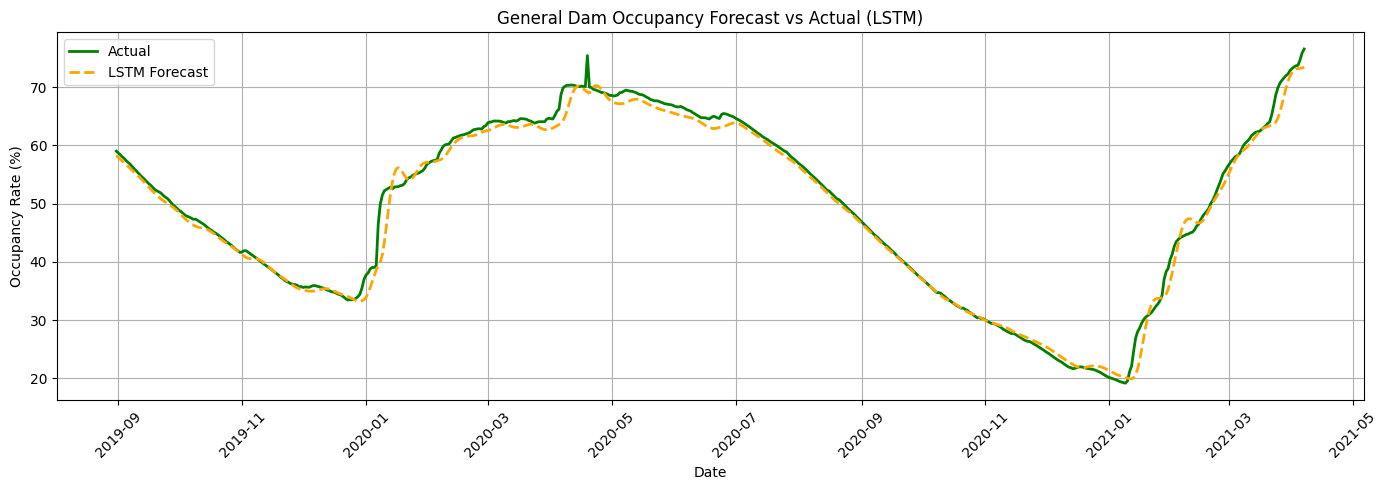

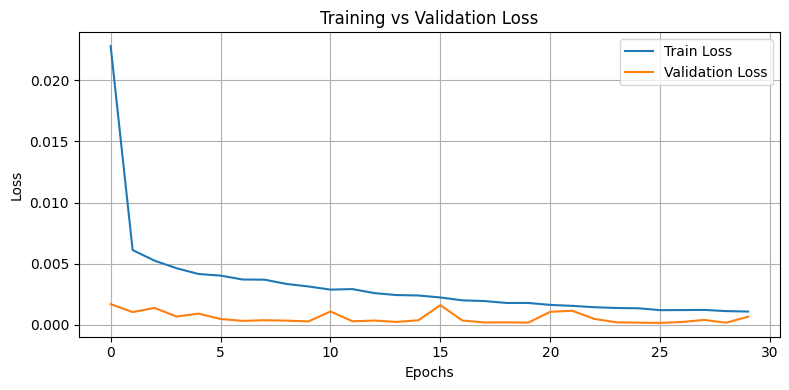

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Assuming df_general is already loaded and processed as you described ---
# Loading cleaned general dataset
df_general = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])
df_general.set_index('DATE', inplace=True) # This line makes 'DATE' the index

# Copying original data and resetting index to make 'DATE' a column again
df_lstm = df_general.copy()
df_lstm = df_lstm.reset_index() # <-- ADD THIS LINE

# Creating lag and rolling features
df_lstm['GENERAL_DAM_OCCUPANCY_RATE_lag1'] = df_lstm['GENERAL_DAM_OCCUPANCY_RATE'].shift(1)
df_lstm['GENERAL_DAM_OCCUPANCY_RATE_rolling7'] = df_lstm['GENERAL_DAM_OCCUPANCY_RATE'].rolling(window=7).mean()
df_lstm['GENERAL_DAM_OCCUPANCY_RATE_rolling30'] = df_lstm['GENERAL_DAM_OCCUPANCY_RATE'].rolling(window=30).mean()

# Dropping NaNs
df_lstm = df_lstm.dropna().reset_index(drop=True)

# Selecting features and target
feature_cols = ['GENERAL_DAM_OCCUPANCY_RATE_lag1', 'GENERAL_DAM_OCCUPANCY_RATE_rolling7', 'GENERAL_DAM_OCCUPANCY_RATE_rolling30']
target_col = 'GENERAL_DAM_OCCUPANCY_RATE'
# Now 'DATE' is a column, so this line will work
dates = df_lstm['DATE'][60:].reset_index(drop=True)  # Aligning with sequences

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_lstm[feature_cols])
y_scaled = scaler_y.fit_transform(df_lstm[[target_col]])

# Creating sequences
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled)

# Splitting into train/val/test
train_size = int(len(X_seq) * 0.8)
val_size = int(len(X_seq) * 0.1)
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
dates_test = dates[train_size + val_size:]

# Building the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

# Making predictions
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Calculating performance
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"LSTM MAE (Test Set): {mae:.2f}")
print(f"LSTM RMSE (Test Set): {rmse:.2f}")

# Plotting forecast vs actual
plt.figure(figsize=(14, 5))
plt.plot(dates_test, y_test_inv, label="Actual", color='green', linewidth=2)
plt.plot(dates_test, y_pred_inv, label="LSTM Forecast", color='orange', linestyle='--', linewidth=2)
plt.title("General Dam Occupancy Forecast vs Actual (LSTM)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting overfit control (loss graph)
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.save("../models/general_dam/stm_univariate_only_occupancy_general.h5")

## Forecasting Next 60 Days Using Recursive LSTM Predictions (General Dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

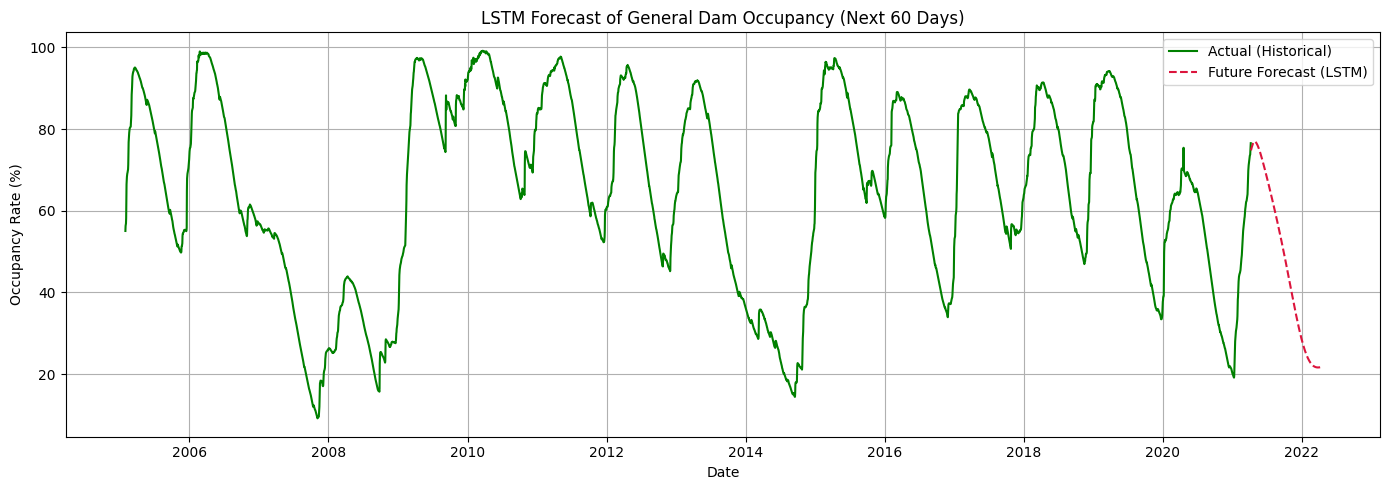

In [10]:
# Forecasting future values using last available sequence
future_steps = 365  # Number of days to forecast
last_sequence = X_seq[-1]  # Taking the last 60-day sequence from original data
forecast_sequence = last_sequence.copy()

future_predictions = []

# Recursive prediction loop
for _ in range(future_steps):
    input_seq = np.expand_dims(forecast_sequence, axis=0)  # (1, 60, 3)
    next_pred = model.predict(input_seq)[0]
    future_predictions.append(next_pred)

    # Creating the next timestep input
    next_input = forecast_sequence[-1].copy()
    next_input[0] = next_pred  # lag1 = predicted value
    # Updating rolling features by simple shifting (can be refined further)
    next_input[1] = (forecast_sequence[-7:, 0].mean() + next_pred[0]) / 2  # new rolling7
    next_input[2] = (forecast_sequence[-30:, 0].mean() + next_pred[0]) / 2  # new rolling30

    forecast_sequence = np.vstack([forecast_sequence[1:], next_input])

# Inverse scaling
future_predictions_inv = scaler_y.inverse_transform(np.array(future_predictions))

# Generating future dates
last_date = df_lstm['DATE'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

# Plotting actual + future forecast
plt.figure(figsize=(14, 5))
plt.plot(df_lstm['DATE'], df_lstm['GENERAL_DAM_OCCUPANCY_RATE'], label="Actual (Historical)", color='green')
plt.plot(future_dates, future_predictions_inv, label="Future Forecast (LSTM)", color='crimson', linestyle='--')
plt.title("LSTM Forecast of General Dam Occupancy (Next 60 Days)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Multivariate LSTM Forecasting on Cleaned General Dam Dataset


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Multivariate LSTM MAE (Test Set): 0.65
Multivariate LSTM RMSE (Test Set): 0.97


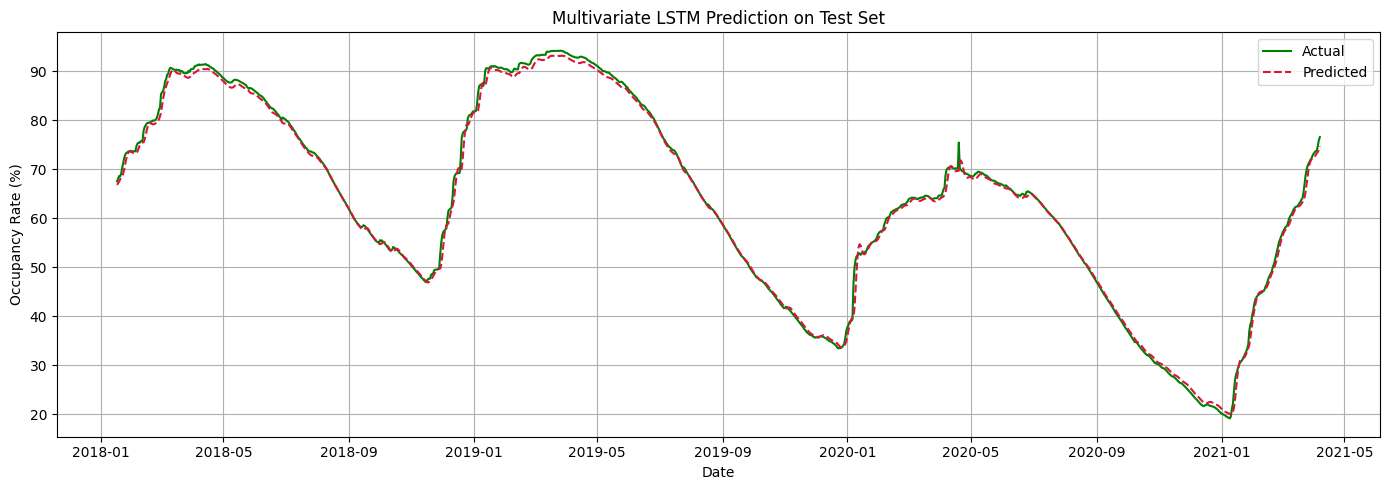

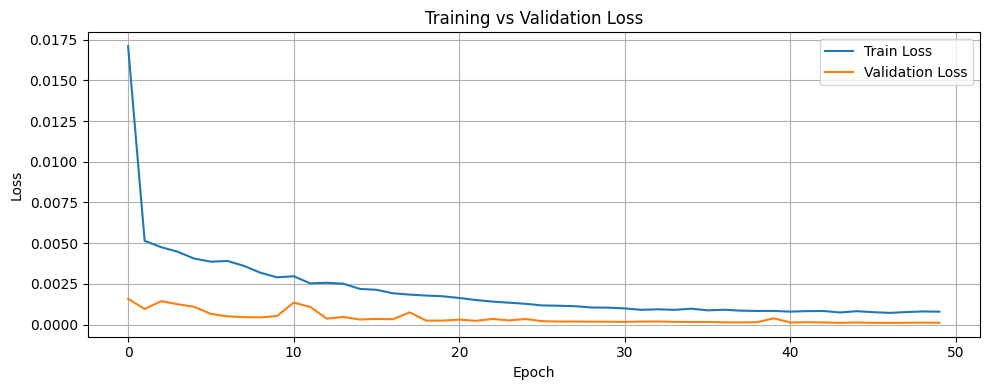

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

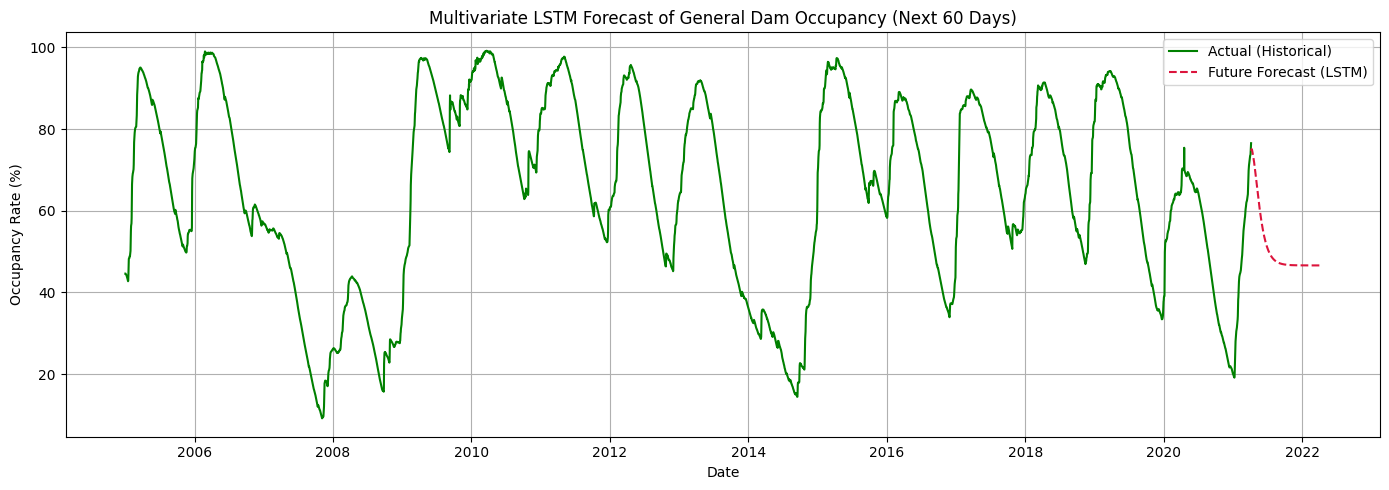

In [32]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Loading cleaned general dam dataset
df_multi = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df_multi['DATE'] = pd.to_datetime(df_multi['DATE'])

# Selecting features and target (multivariate inputs)
features = ['GENERAL_DAM_RESERVED_WATER']
target = ['GENERAL_DAM_OCCUPANCY_RATE']
df_model = df_multi[features + target].copy()

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_model[features])
y_scaled = scaler_y.fit_transform(df_model[target])

# Creating input sequences
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)
date_seq = df_multi['DATE'][60:].reset_index(drop=True)

# Train/val/test split
train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.1)
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
date_test = date_seq[train_size + val_size:]

# Building the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Test set prediction
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Evaluation metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Multivariate LSTM MAE (Test Set): {round(mae, 2)}")
print(f"Multivariate LSTM RMSE (Test Set): {round(rmse, 2)}")

# Plotting predictions vs actual
plt.figure(figsize=(14, 5))
plt.plot(date_test, y_test_inv, label="Actual", color='green')
plt.plot(date_test, y_pred_inv, label="Predicted", color='crimson', linestyle='--')
plt.title("Multivariate LSTM Prediction on Test Set")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting loss curve
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# Forecasting next 60 days
# ==============================

future_steps = 365
forecast_input = X_seq[-1]
future_forecast = []

for _ in range(future_steps):
    input_seq = np.expand_dims(forecast_input, axis=0)
    next_pred = model.predict(input_seq)[0]
    future_forecast.append(next_pred)

    next_input = forecast_input[-1].copy()
    next_input[0] = next_pred[0]
    forecast_input = np.vstack([forecast_input[1:], next_input])

# Inverse scaling
future_forecast_inv = scaler_y.inverse_transform(np.array(future_forecast))
last_date = df_multi['DATE'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

# Plotting actual + future forecast
plt.figure(figsize=(14, 5))
plt.plot(df_multi['DATE'], df_multi['GENERAL_DAM_OCCUPANCY_RATE'], label="Actual (Historical)", color='green')
plt.plot(future_dates, future_forecast_inv, label="Future Forecast (LSTM)", color='crimson', linestyle='--')
plt.title("Multivariate LSTM Forecast of General Dam Occupancy (Next 60 Days)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.save("../models/general_dam/lstm_multivariate_only_occupancy_general.h5")



## Prophet Forecasting for Each Dam (Occupancy Only)


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None


DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\s46tf30q.json



Training Prophet model for: Omerli


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\wp9jnkh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=67066', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\s46tf30q.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\wp9jnkh1.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelquk99enc\\prophet_model-20250629215818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Omerli - Prophet MAE: 0.1 | RMSE: 0.13


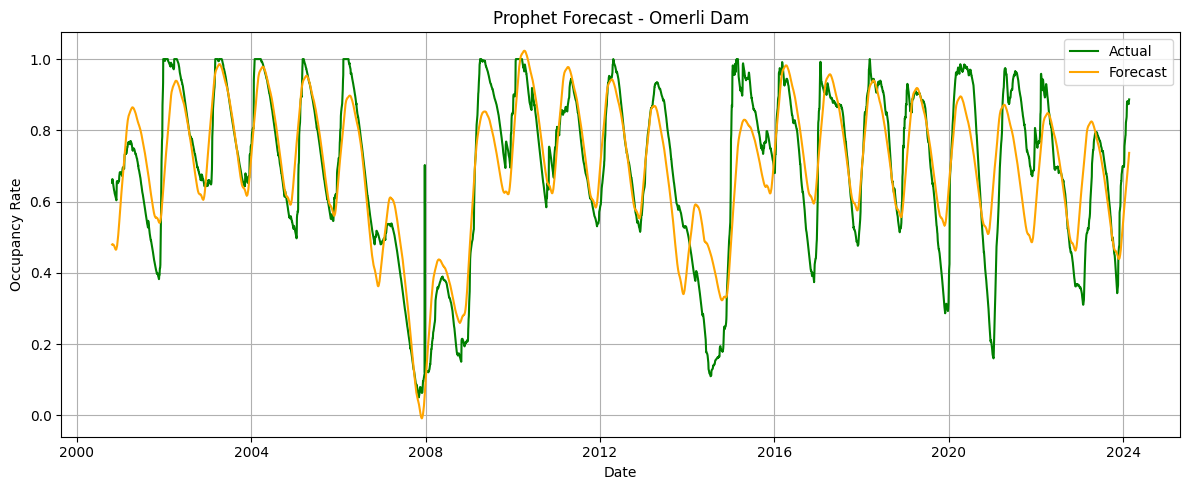

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


Model saved as: ../models/multivariate_models_only_occupancy/prophet_omerli.pkl

Training Prophet model for: Darlik


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\04mavgsp.json
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\9gjdsndo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=63183', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\04mavgsp.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\9gjdsndo.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelrgkeknmh\\prophet_model-20250629215822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:26 - cmdstanpy - INFO - Chain [1] done processing
INFO

Darlik - Prophet MAE: 0.14 | RMSE: 0.17


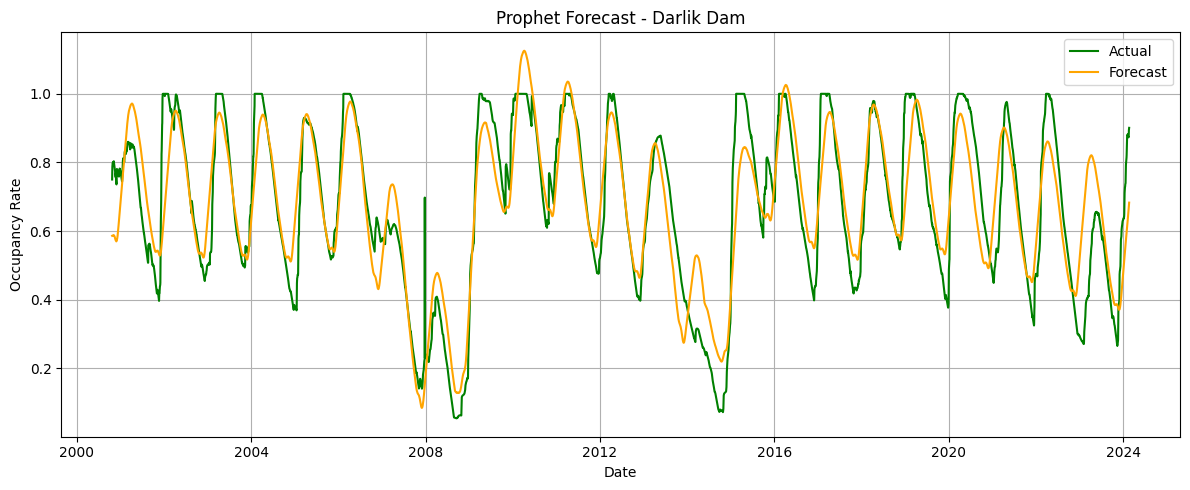

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


Model saved as: ../models/multivariate_models_only_occupancy/prophet_darlik.pkl

Training Prophet model for: Elmali


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\l0j_2d8_.json
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\4cmkvrzf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=66959', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\l0j_2d8_.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\4cmkvrzf.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelod4nwe1x\\prophet_model-20250629215829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO

Elmali - Prophet MAE: 0.3 | RMSE: 0.3


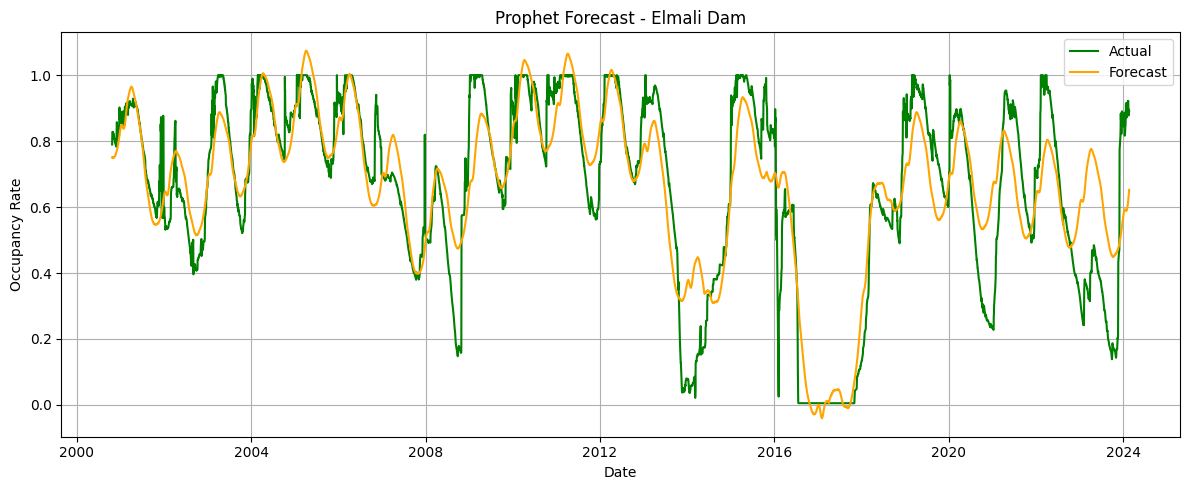

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


Model saved as: ../models/multivariate_models_only_occupancy/prophet_elmali.pkl

Training Prophet model for: Terkos


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\wocks6zr.json
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\c_7va0hd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=46631', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\wocks6zr.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\c_7va0hd.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelzb_y3fd7\\prophet_model-20250629215834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:36 - cmdstanpy - INFO - Chain [1] done processing
INFO

Terkos - Prophet MAE: 0.22 | RMSE: 0.23


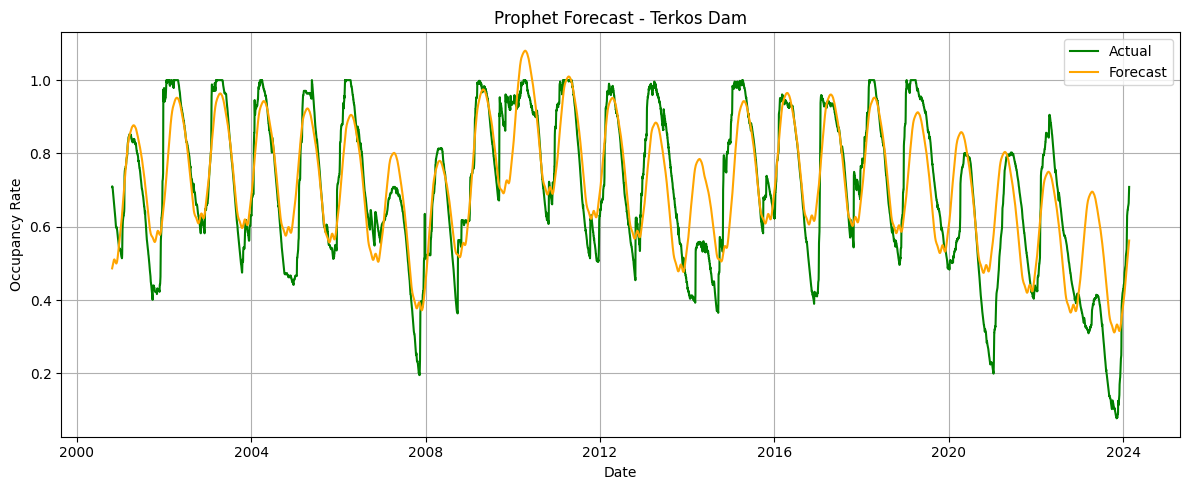

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None


Model saved as: ../models/multivariate_models_only_occupancy/prophet_terkos.pkl

Training Prophet model for: Alibey


DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\ip38ahkm.json
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\fqcsyg0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=60337', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\ip38ahkm.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\fqcsyg0t.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_model17wp0v7j\\prophet_model-20250629215838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:41 - cm

Alibey - Prophet MAE: 0.23 | RMSE: 0.28


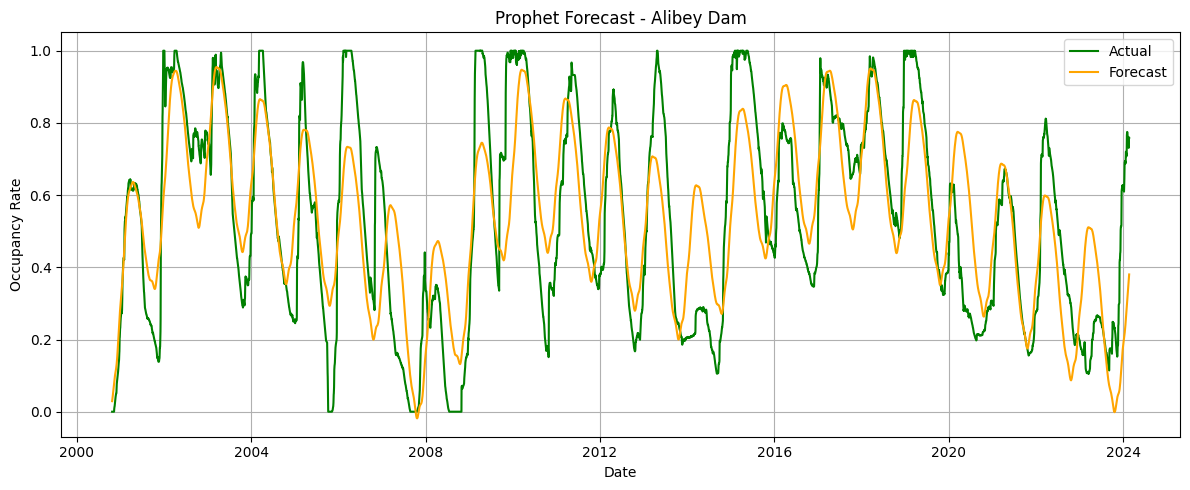

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\7_nwoijr.json


Model saved as: ../models/multivariate_models_only_occupancy/prophet_alibey.pkl

Training Prophet model for: Buyukcekmece


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\03jvlgpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=98297', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\7_nwoijr.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\03jvlgpl.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_model8h8m__72\\prophet_model-20250629215843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Buyukcekmece - Prophet MAE: 0.27 | RMSE: 0.29


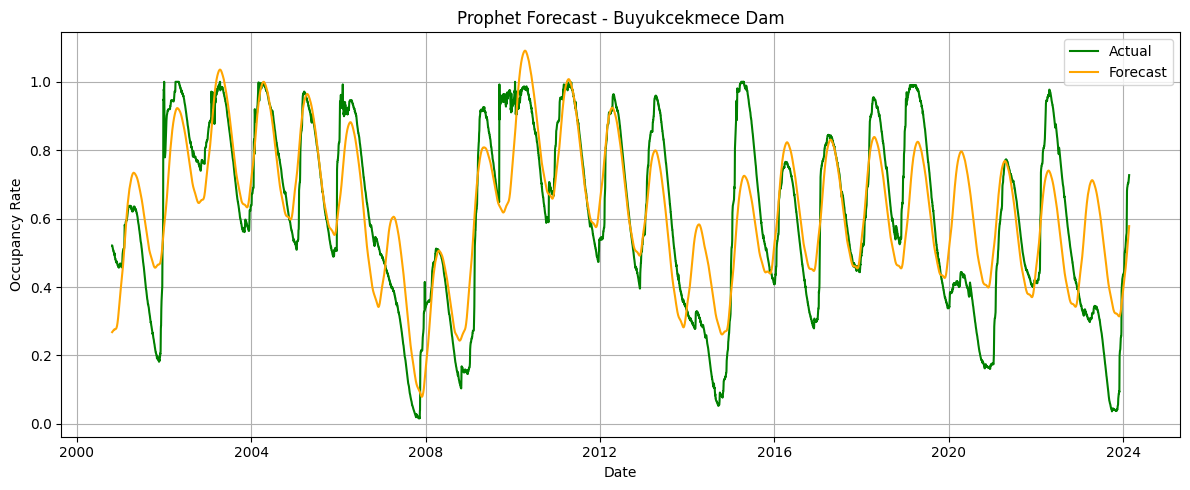

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\ol97arz7.json


Model saved as: ../models/multivariate_models_only_occupancy/prophet_buyukcekmece.pkl

Training Prophet model for: Sazlidere


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\os47ylb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=68811', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\ol97arz7.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\os47ylb3.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelbj2wqruq\\prophet_model-20250629215848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Sazlidere - Prophet MAE: 0.17 | RMSE: 0.19


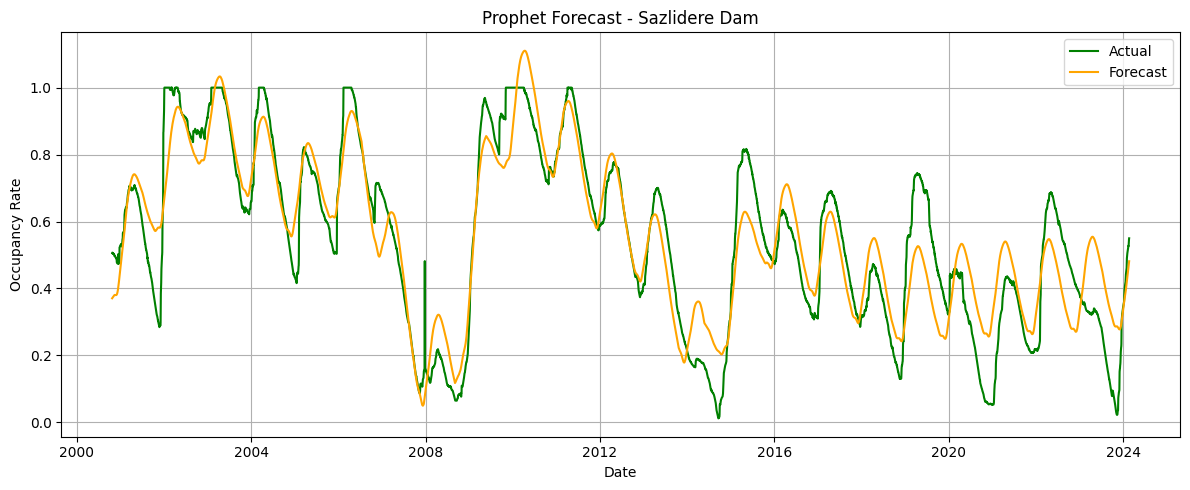

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\_sg8ukm0.json


Model saved as: ../models/multivariate_models_only_occupancy/prophet_sazlidere.pkl

Training Prophet model for: Kazandere


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\q8kn8n5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=78817', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\_sg8ukm0.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\q8kn8n5v.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_model0fpyghu7\\prophet_model-20250629215854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Kazandere - Prophet MAE: 0.21 | RMSE: 0.24


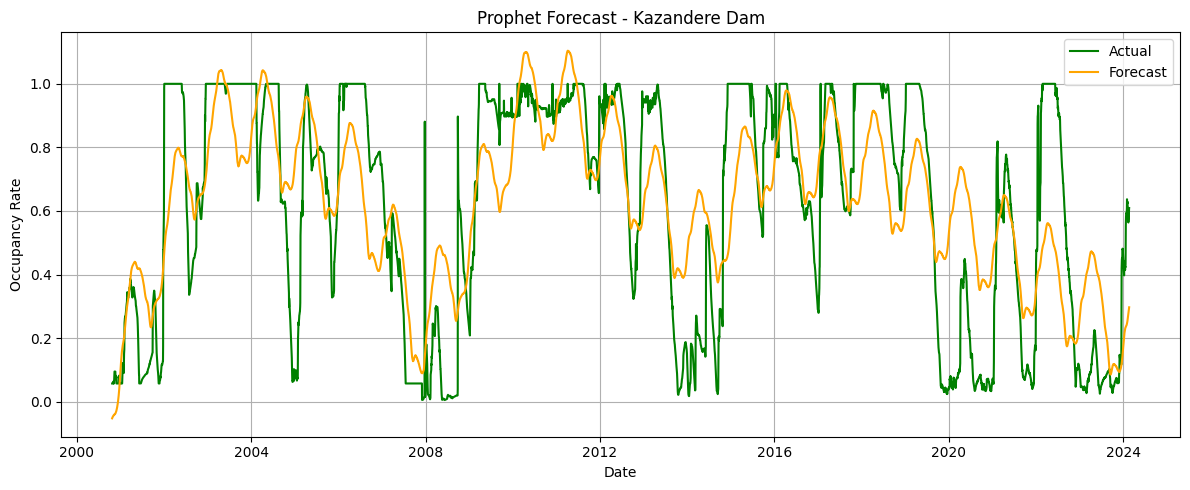

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\8hipdjnl.json


Model saved as: ../models/multivariate_models_only_occupancy/prophet_kazandere.pkl

Training Prophet model for: Pabucdere


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\4oq845q6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=43276', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\8hipdjnl.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\4oq845q6.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelsvqeh4nf\\prophet_model-20250629215859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:59:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Pabucdere - Prophet MAE: 0.16 | RMSE: 0.19


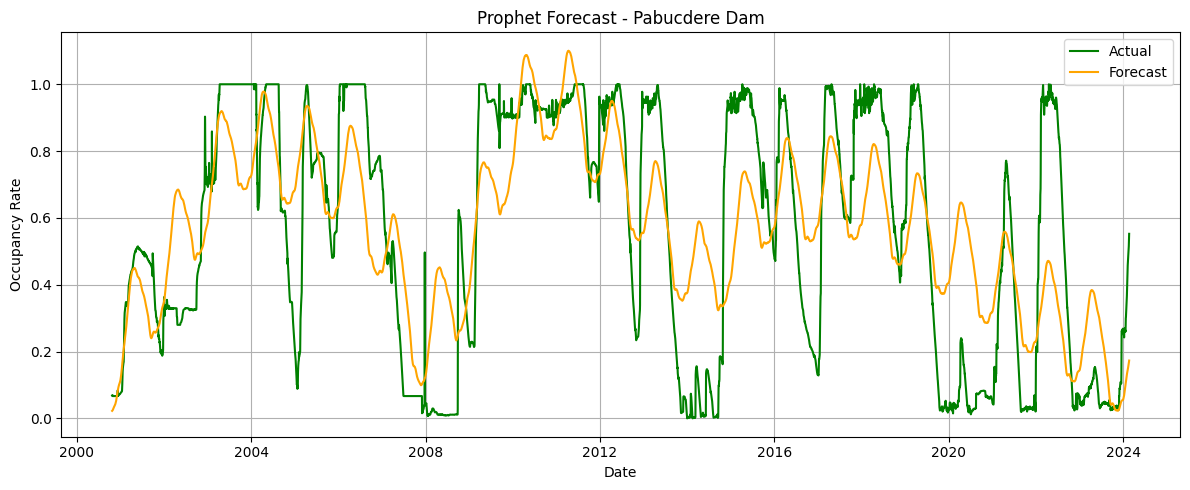

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\6m7lifjv.json


Model saved as: ../models/multivariate_models_only_occupancy/prophet_pabucdere.pkl

Training Prophet model for: Istrancalar


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\m7mtj0wk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=16693', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\6m7lifjv.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\m7mtj0wk.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelpu2knzwy\\prophet_model-20250629215904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:59:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Istrancalar - Prophet MAE: 0.13 | RMSE: 0.17


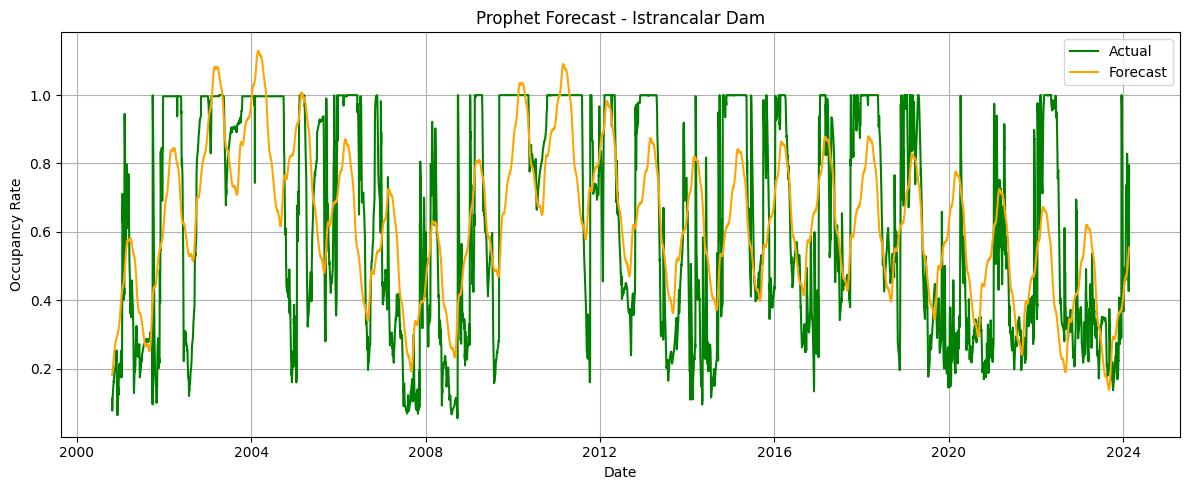

Model saved as: ../models/multivariate_models_only_occupancy/prophet_istrancalar.pkl


In [21]:
# Importing necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Loading cleaned dam-specific dataset
df_dams = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])

# Creating output directory for models if not exists
os.makedirs("../models/prophet_dam_specific", exist_ok=True)

# Iterating over each dam column
dam_columns = df_dams.columns.drop('Tarih')

for dam in dam_columns:
    print(f"\nTraining Prophet model for: {dam}")

    # Preparing dataset for Prophet
    df_prophet = df_dams[['Tarih', dam]].rename(columns={'Tarih': 'ds', dam: 'y'})

    # Splitting into train and test (last 60 days as test)
    df_train = df_prophet[:-360]
    df_test = df_prophet[-360:]

    # Initializing and fitting the model
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(df_train)

    # Forecasting future including test period
    future = model.make_future_dataframe(periods=360)
    forecast = model.predict(future)

    # Extracting prediction corresponding to test dates
    forecast_test = forecast.set_index('ds').loc[df_test['ds']]
    predicted = forecast_test['yhat'].values
    actual = df_test['y'].values

    # Calculating metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"{dam} - Prophet MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(df_prophet['ds'], df_prophet['y'], label="Actual", color="green")
    plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="orange")
    plt.title(f"Prophet Forecast - {dam} Dam")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    import joblib

    # Saving the trained Prophet model
    joblib.dump(model, f"../models/multivariate_models_only_occupancy/prophet_{dam.lower()}.pkl")
    print(f"Model saved as: ../models/multivariate_models_only_occupancy/prophet_{dam.lower()}.pkl")






## SARIMA Forecasting on Dam-Specific Datasets


Training SARIMA model for: Omerli
Selected SARIMA Order for Omerli: (3, 1, 4)
Omerli - SARIMA MAE: 0.11 | RMSE: 0.14


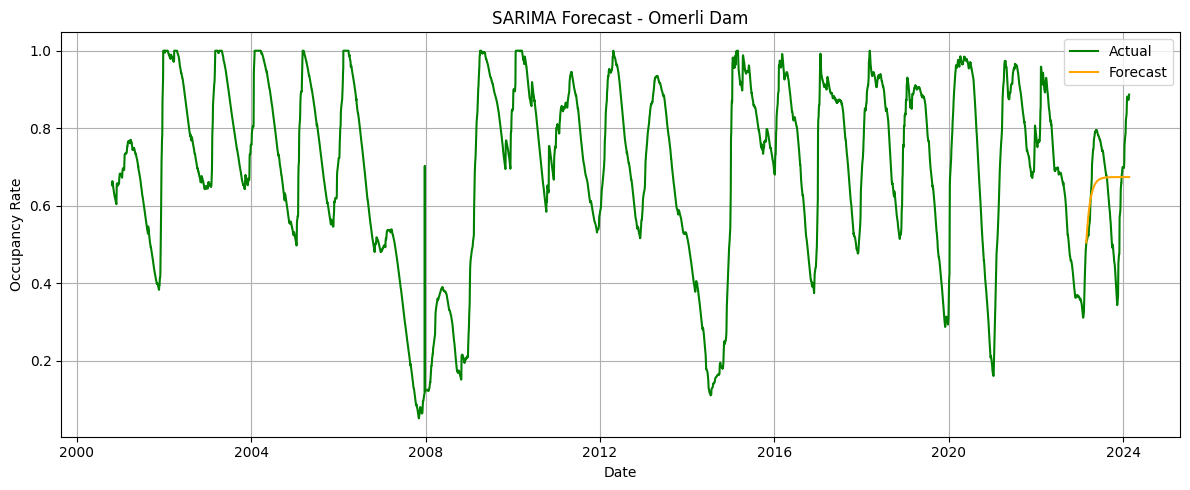

Model saved: ../models/multivariate_models_only_occupancy/sarima_omerli.pkl

Training SARIMA model for: Darlik
Selected SARIMA Order for Darlik: (4, 1, 2)
Darlik - SARIMA MAE: 0.12 | RMSE: 0.16


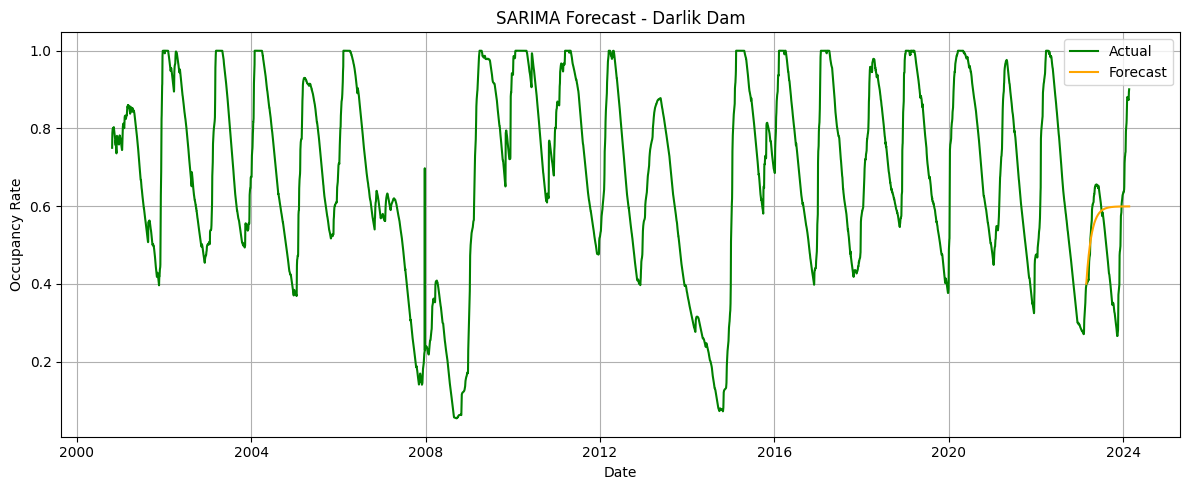

Model saved: ../models/multivariate_models_only_occupancy/sarima_darlik.pkl

Training SARIMA model for: Elmali
Selected SARIMA Order for Elmali: (4, 1, 2)
Elmali - SARIMA MAE: 0.19 | RMSE: 0.25


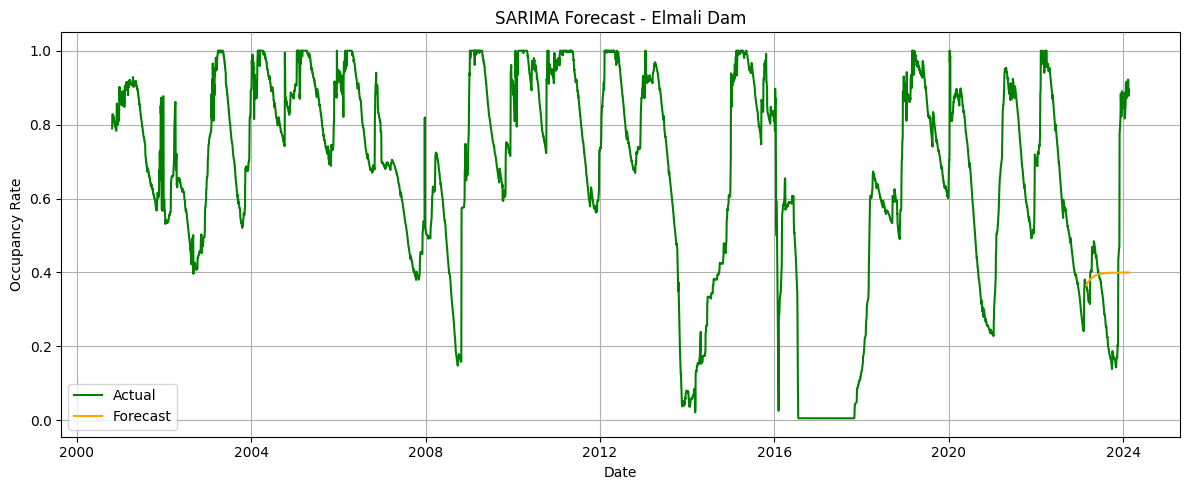

Model saved: ../models/multivariate_models_only_occupancy/sarima_elmali.pkl

Training SARIMA model for: Terkos
Selected SARIMA Order for Terkos: (1, 1, 3)
Terkos - SARIMA MAE: 0.12 | RMSE: 0.15


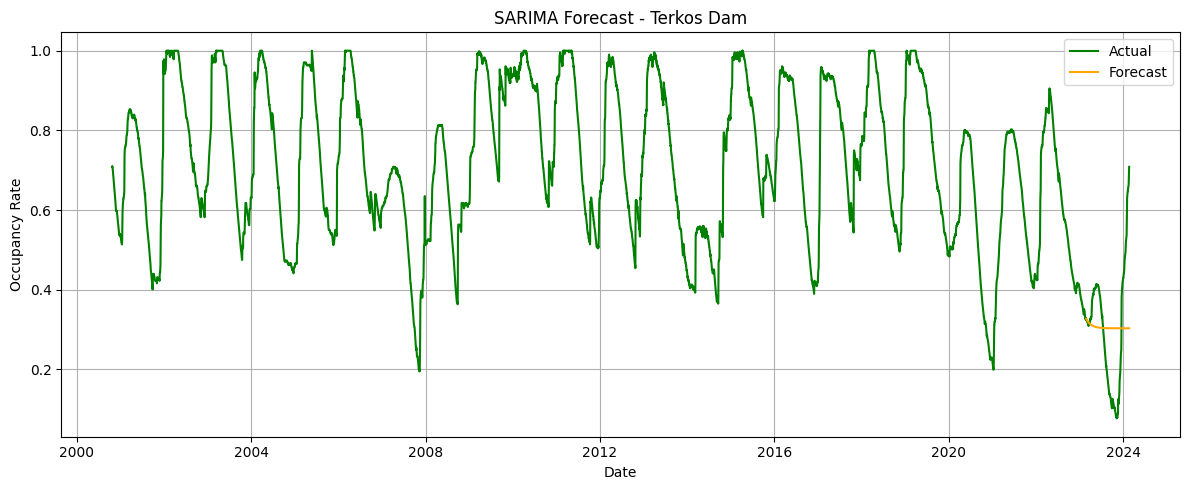

Model saved: ../models/multivariate_models_only_occupancy/sarima_terkos.pkl

Training SARIMA model for: Alibey
Selected SARIMA Order for Alibey: (1, 1, 3)
Alibey - SARIMA MAE: 0.21 | RMSE: 0.29


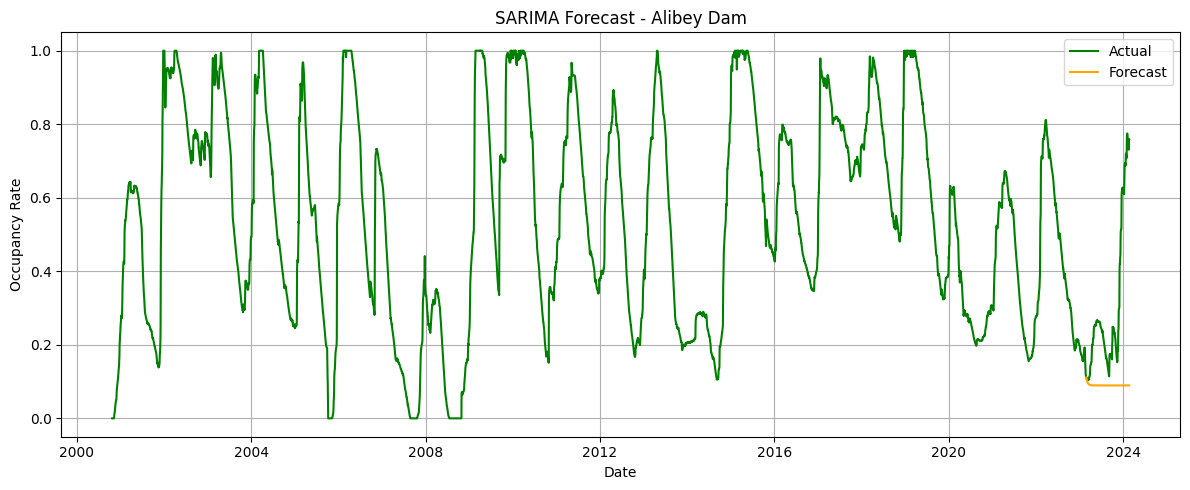

Model saved: ../models/multivariate_models_only_occupancy/sarima_alibey.pkl

Training SARIMA model for: Buyukcekmece
Selected SARIMA Order for Buyukcekmece: (1, 1, 0)
Buyukcekmece - SARIMA MAE: 0.14 | RMSE: 0.19


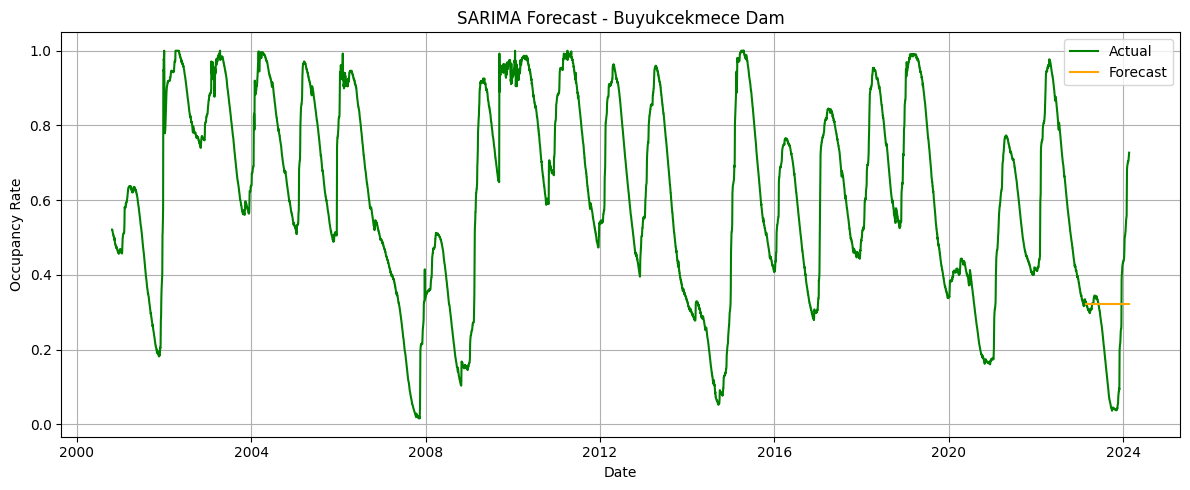

Model saved: ../models/multivariate_models_only_occupancy/sarima_buyukcekmece.pkl

Training SARIMA model for: Sazlidere
Selected SARIMA Order for Sazlidere: (3, 1, 5)
Sazlidere - SARIMA MAE: 0.11 | RMSE: 0.14


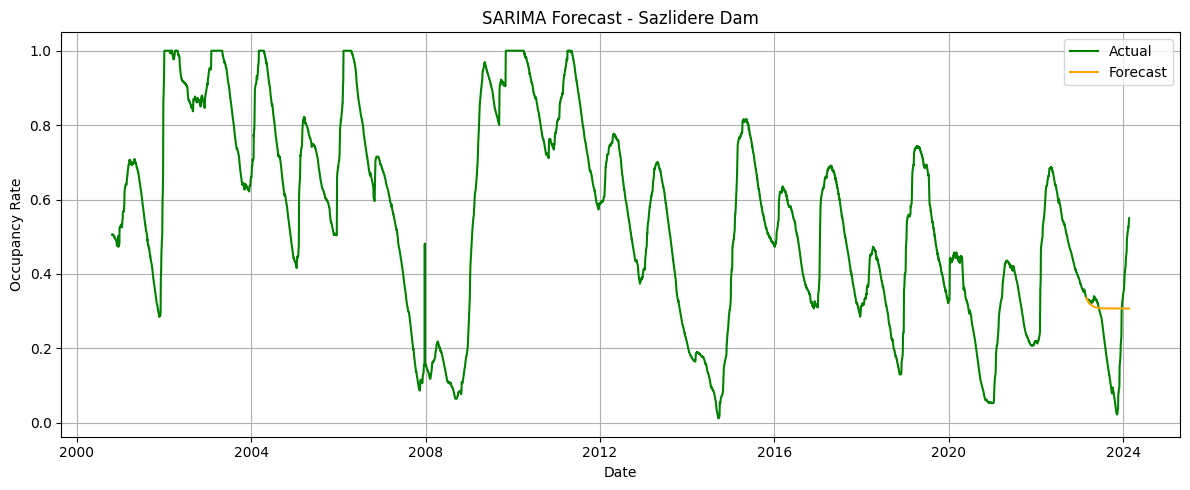

Model saved: ../models/multivariate_models_only_occupancy/sarima_sazlidere.pkl

Training SARIMA model for: Kazandere
Selected SARIMA Order for Kazandere: (1, 1, 3)
Kazandere - SARIMA MAE: 0.13 | RMSE: 0.22


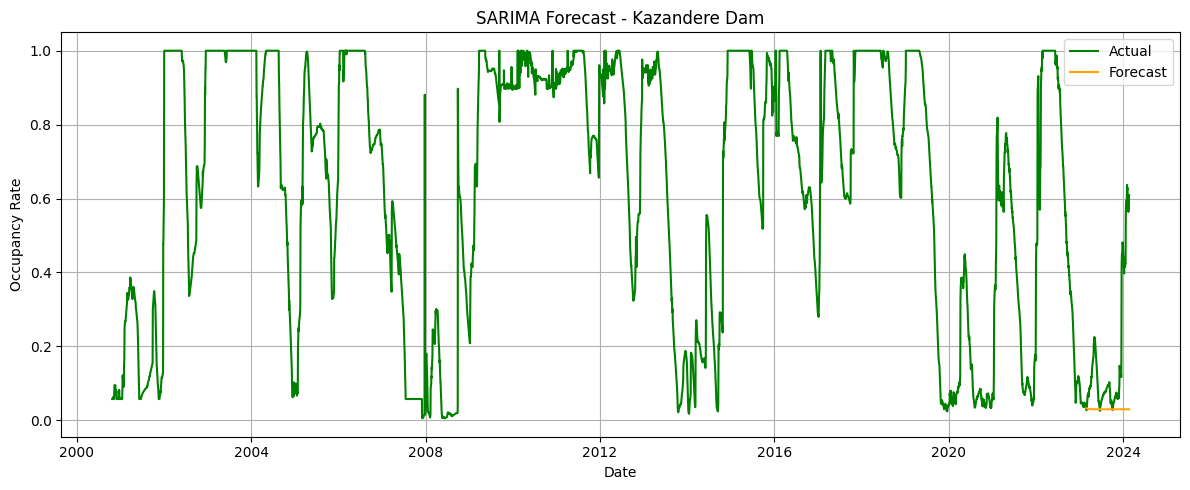

Model saved: ../models/multivariate_models_only_occupancy/sarima_kazandere.pkl

Training SARIMA model for: Pabucdere
Selected SARIMA Order for Pabucdere: (2, 1, 1)
Pabucdere - SARIMA MAE: 0.07 | RMSE: 0.12


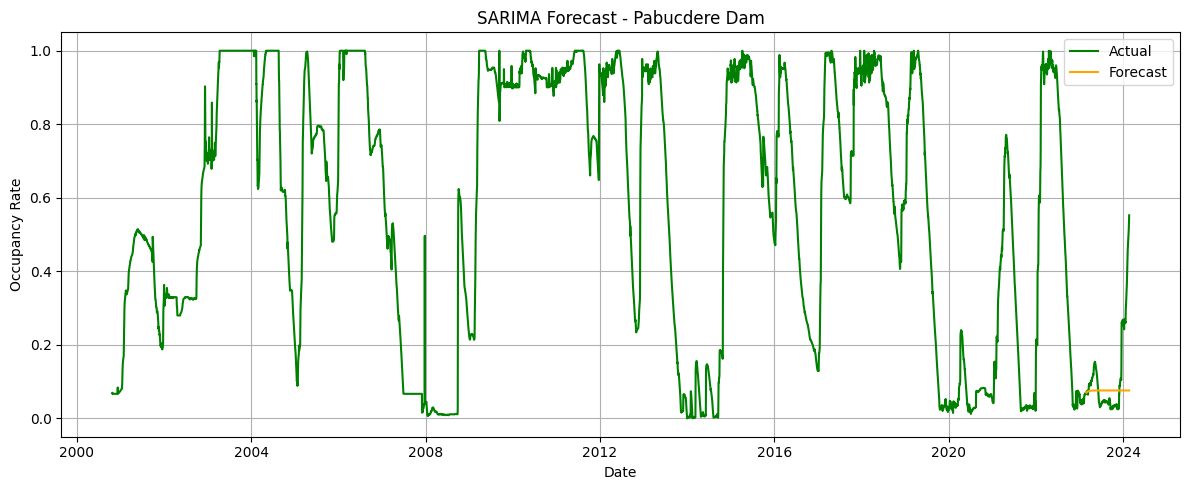

Model saved: ../models/multivariate_models_only_occupancy/sarima_pabucdere.pkl

Training SARIMA model for: Istrancalar
Selected SARIMA Order for Istrancalar: (3, 1, 4)
Istrancalar - SARIMA MAE: 0.13 | RMSE: 0.17


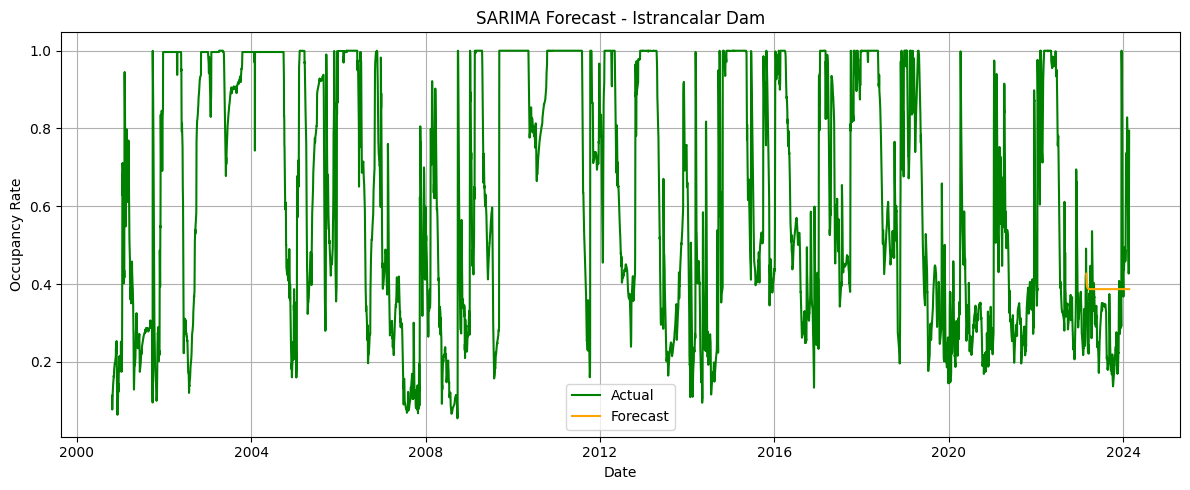

Model saved: ../models/multivariate_models_only_occupancy/sarima_istrancalar.pkl


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import warnings
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

# Loading cleaned dam-specific dataset
df_dams = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])

# Output directory
os.makedirs("../models/multivariate_models_only_occupancy", exist_ok=True)

# List of dam columns (excluding date)
dam_columns = df_dams.columns.drop('Tarih')

for dam in dam_columns:
    print(f"\nTraining SARIMA model for: {dam}")
    
    # Preparing time series
    series = df_dams.set_index('Tarih')[dam]

    # Splitting (last 60 days as test)
    train = series[:-360]
    test = series[-360:]

    # Finding best SARIMA parameters
    model_auto = auto_arima(train, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True)
    order = model_auto.order
    print(f"Selected SARIMA Order for {dam}: {order}")

    # Fitting the model
    model = sm.tsa.ARIMA(train, order=order)
    results = model.fit()

    # Forecasting
    forecast = results.forecast(steps=360)

    # Evaluation
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f"{dam} - SARIMA MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(series.index, series.values, label="Actual", color="green")
    plt.plot(test.index, forecast, label="Forecast", color="orange")
    plt.title(f"SARIMA Forecast - {dam} Dam")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Saving the model
    model_path = f"../models/multivariate_models_only_occupancy/sarima_{dam.lower()}.pkl"
    joblib.dump(results, model_path)
    print(f"Model saved: {model_path}")


## Univariate LSTM for Dam-Specific Forecasting


Training Univariate LSTM for: Omerli
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Omerli - LSTM MAE: 0.01 | RMSE: 0.01


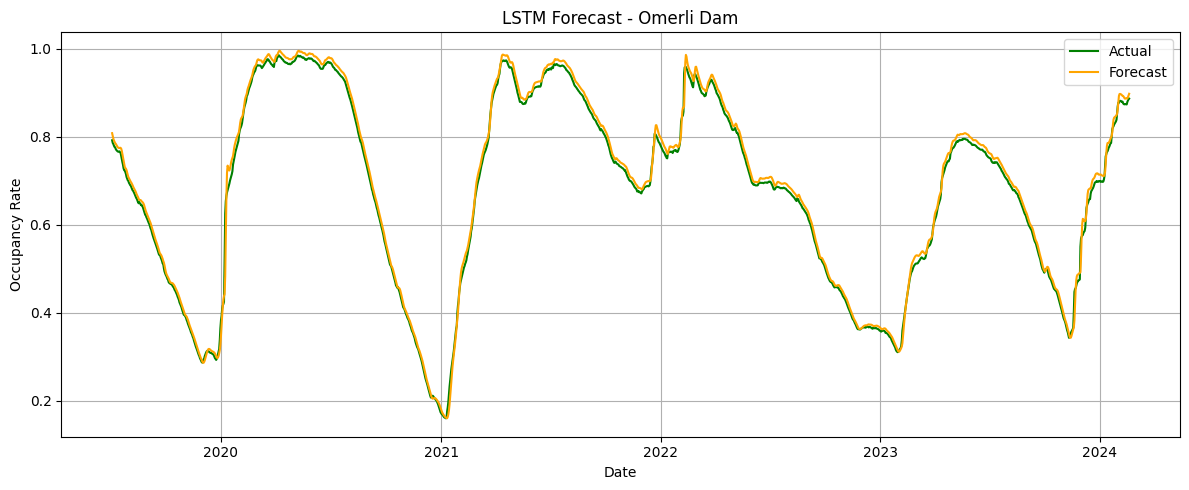

Model and scaler saved for Omerli

Training Univariate LSTM for: Darlik
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Darlik - LSTM MAE: 0.01 | RMSE: 0.01


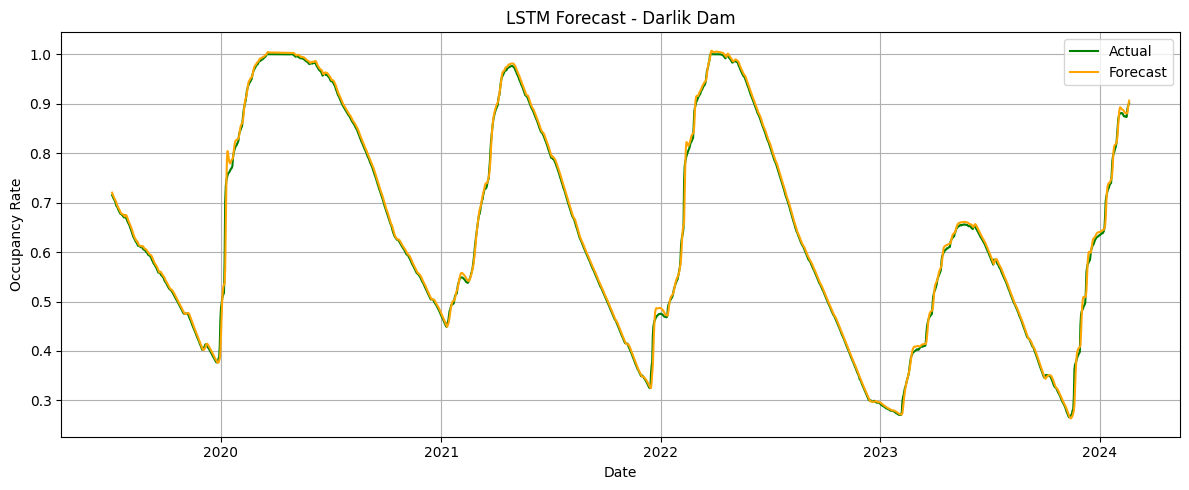

Model and scaler saved for Darlik

Training Univariate LSTM for: Elmali
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Elmali - LSTM MAE: 0.0 | RMSE: 0.01


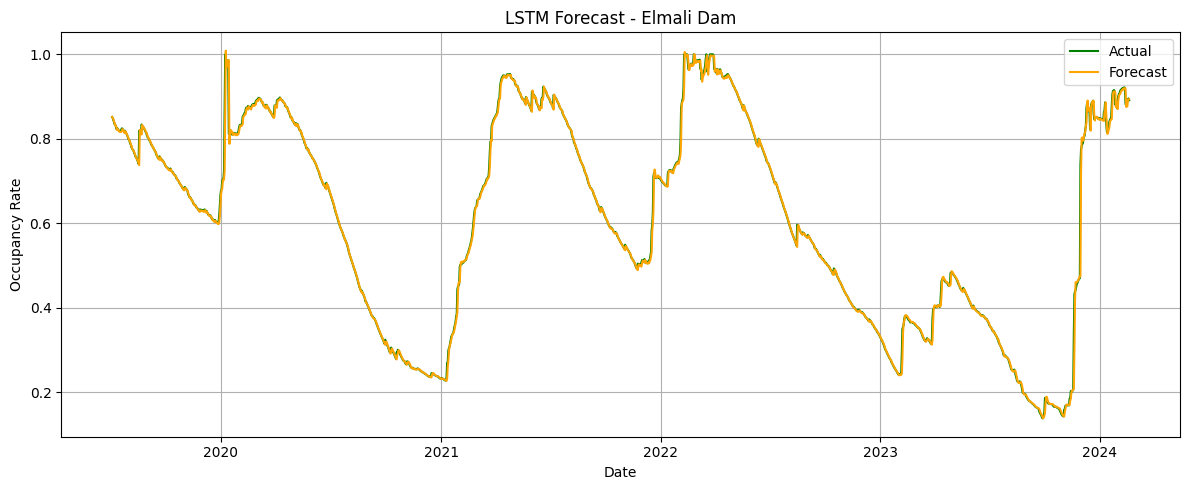

Model and scaler saved for Elmali

Training Univariate LSTM for: Terkos
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Terkos - LSTM MAE: 0.0 | RMSE: 0.01


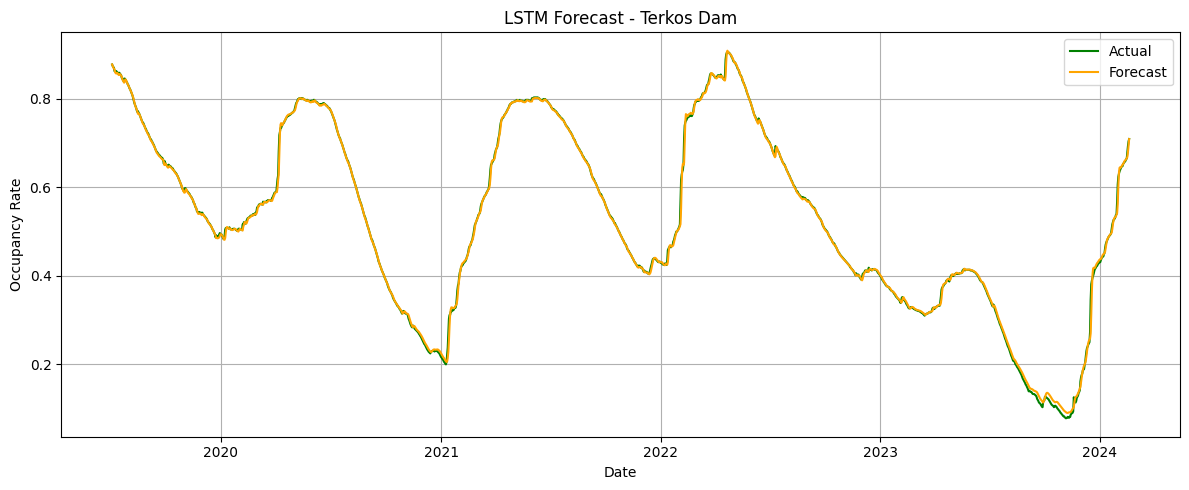

Model and scaler saved for Terkos

Training Univariate LSTM for: Alibey
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Alibey - LSTM MAE: 0.0 | RMSE: 0.01


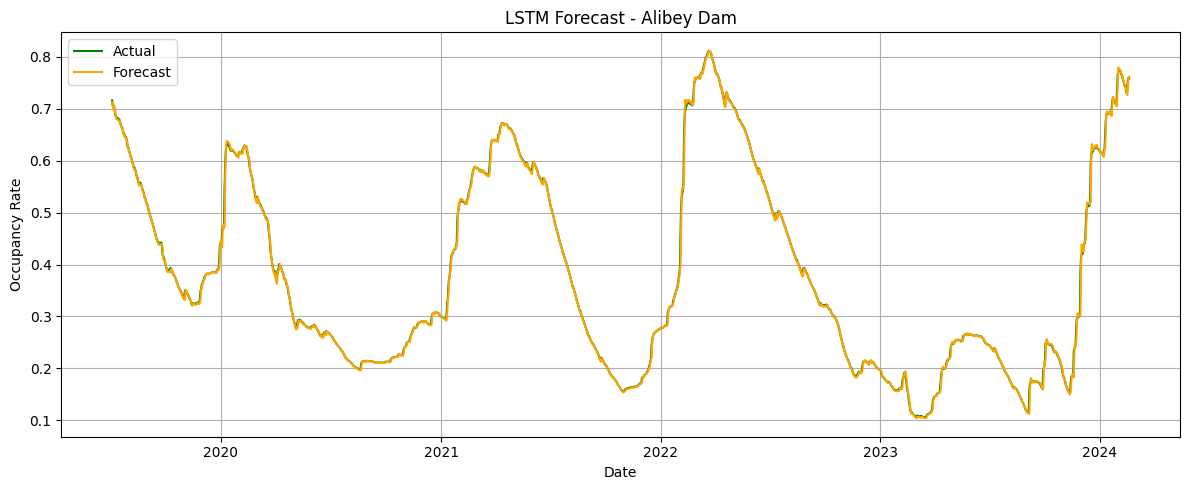

Model and scaler saved for Alibey

Training Univariate LSTM for: Buyukcekmece
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Buyukcekmece - LSTM MAE: 0.01 | RMSE: 0.01


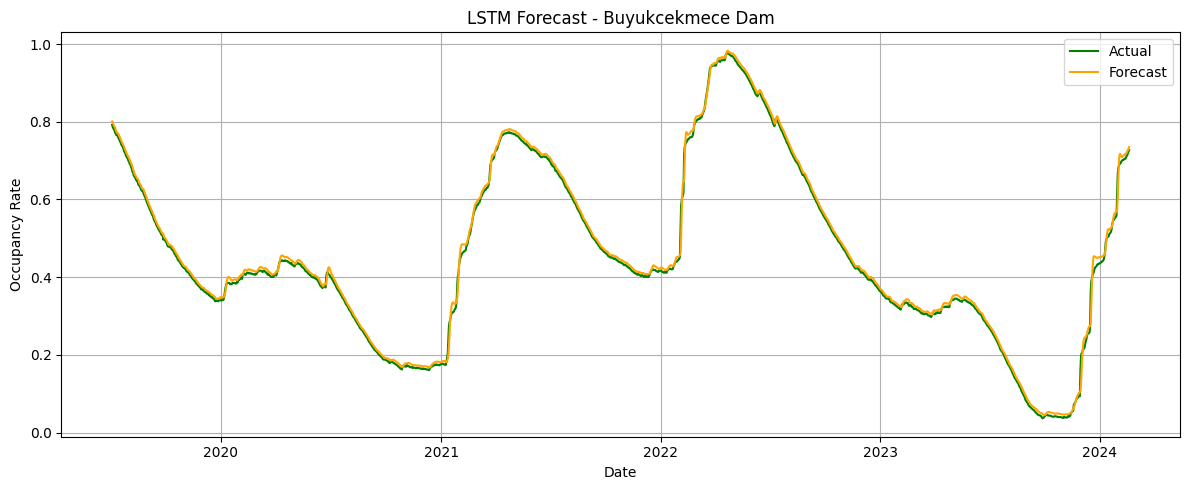

Model and scaler saved for Buyukcekmece

Training Univariate LSTM for: Sazlidere
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Sazlidere - LSTM MAE: 0.0 | RMSE: 0.01


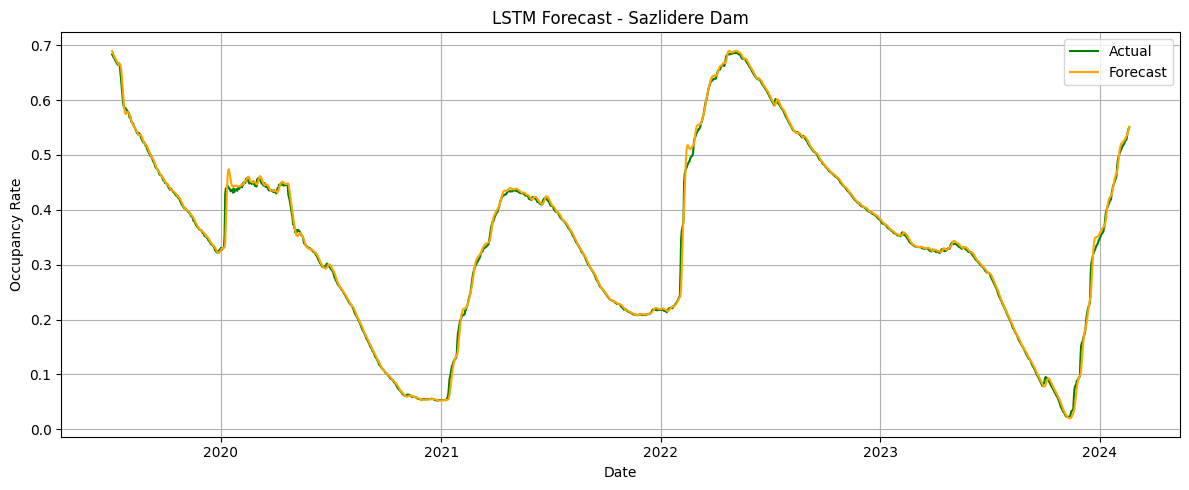

Model and scaler saved for Sazlidere

Training Univariate LSTM for: Kazandere
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Kazandere - LSTM MAE: 0.02 | RMSE: 0.02


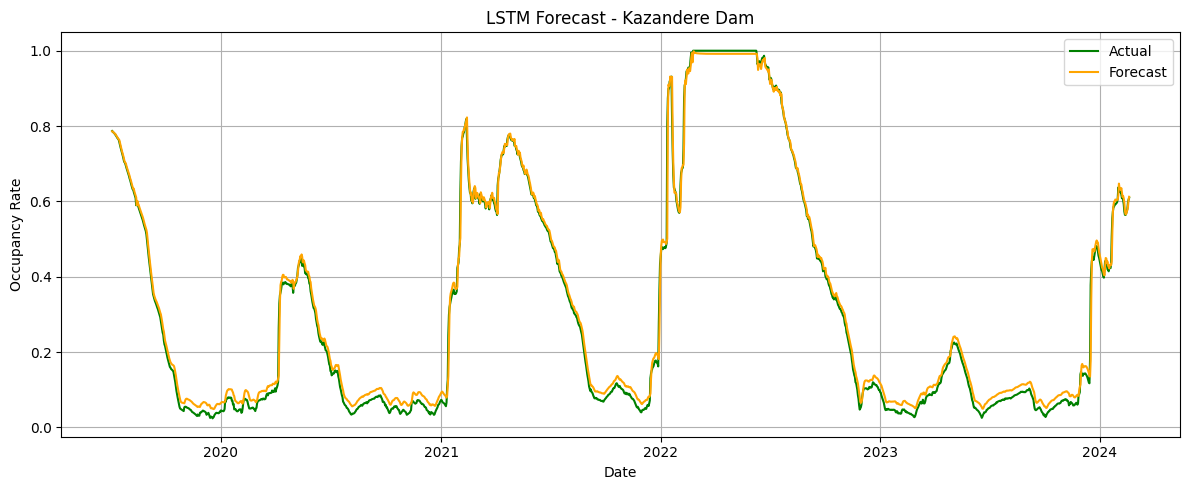

Model and scaler saved for Kazandere

Training Univariate LSTM for: Pabucdere
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Pabucdere - LSTM MAE: 0.0 | RMSE: 0.01


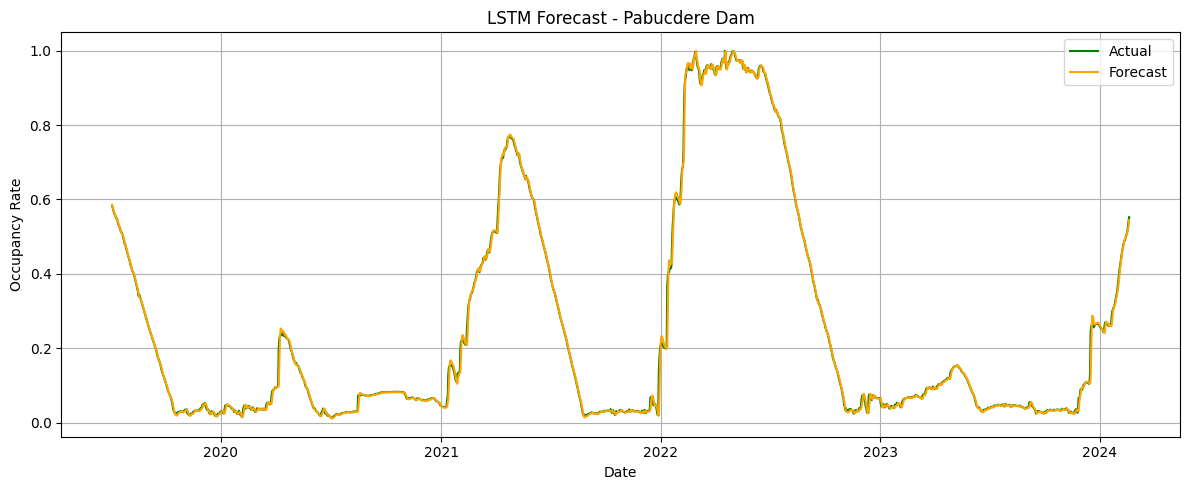

Model and scaler saved for Pabucdere

Training Univariate LSTM for: Istrancalar
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Istrancalar - LSTM MAE: 0.02 | RMSE: 0.04


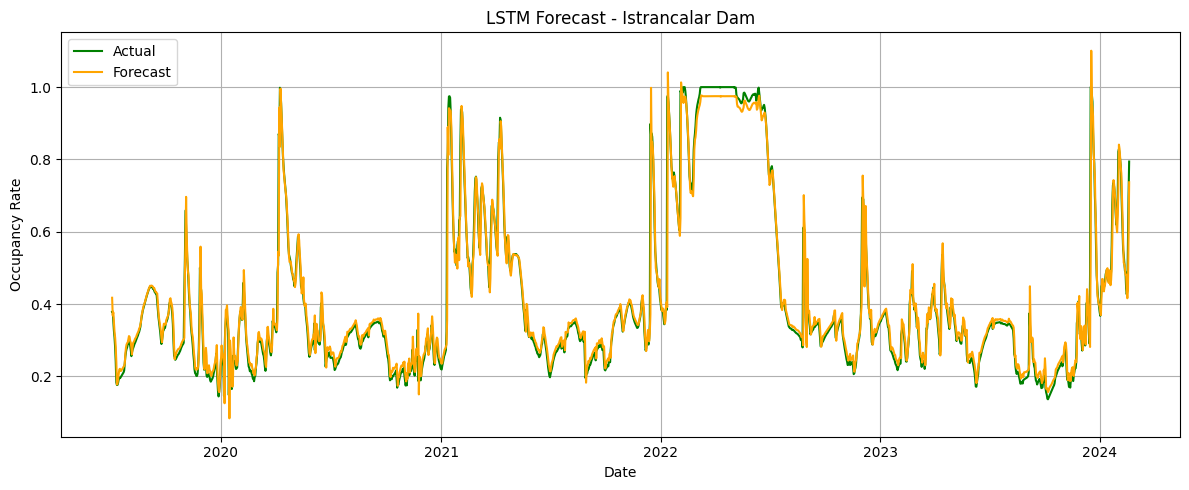

Model and scaler saved for Istrancalar


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import joblib

# Creating output directories
os.makedirs("../models/multivariate_models_only_occupancy/lstm_univariate", exist_ok=True)
os.makedirs("../models/multivariate_models_only_occupancy/lstm_univariate/scalers", exist_ok=True)

# Loading cleaned dam-specific dataset
df = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df['Tarih'] = pd.to_datetime(df['Tarih'])

dam_columns = df.columns.drop('Tarih')

# Feature engineering function
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

for dam in dam_columns:
    print(f"\nTraining Univariate LSTM for: {dam}")

    series = df[[dam]].values

    # Normalizing
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series)

    # Creating sequences
    time_steps = 60
    X, y = create_sequences(series_scaled, time_steps)

    # Train/val/test split
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.1)
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Model building
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=0)

    # Evaluation
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f"{dam} - LSTM MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # Plot
    test_dates = df['Tarih'][len(df) - len(y_test):].reset_index(drop=True)
    plt.figure(figsize=(12, 5))
    plt.plot(test_dates, y_test_inv, label="Actual", color="green")
    plt.plot(test_dates, y_pred_inv, label="Forecast", color="orange")
    plt.title(f"LSTM Forecast - {dam} Dam")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Saving model and scaler
    model.save(f"../models/multivariate_models_only_occupancy/lstm_univariate/lstm_{dam.lower()}.h5")
    joblib.dump(scaler, f"../models/multivariate_models_only_occupancy/lstm_univariate/scalers/scaler_{dam.lower()}.pkl")
    print(f"Model and scaler saved for {dam}")


## Multivariate LSTM for Dam-Specific Forecasting 


Training Multivariate LSTM for: Omerli


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Omerli - Multivariate LSTM MAE: 0.01 | RMSE: 0.02


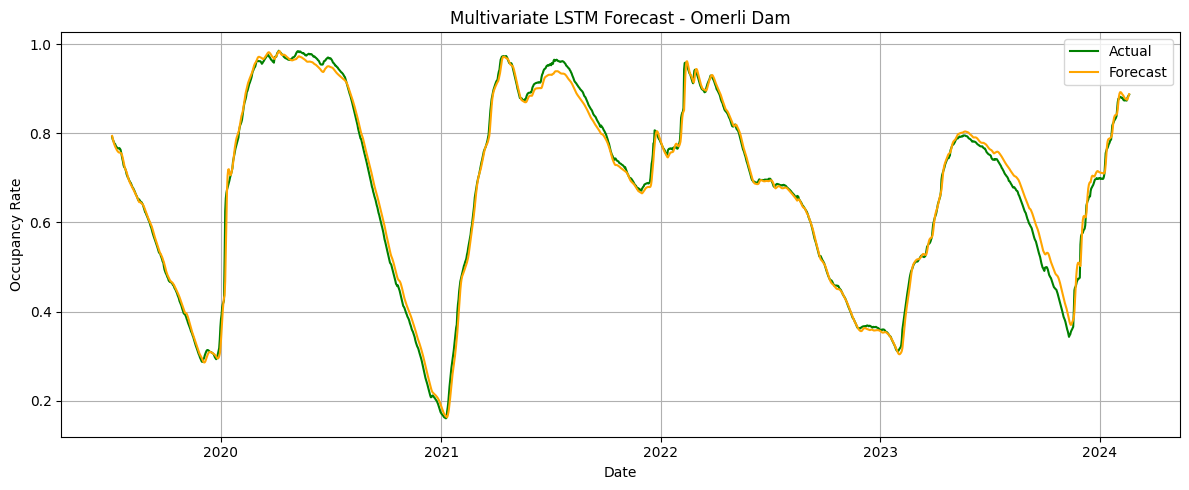

Model and scaler saved for Omerli

Training Multivariate LSTM for: Darlik


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Darlik - Multivariate LSTM MAE: 0.01 | RMSE: 0.01


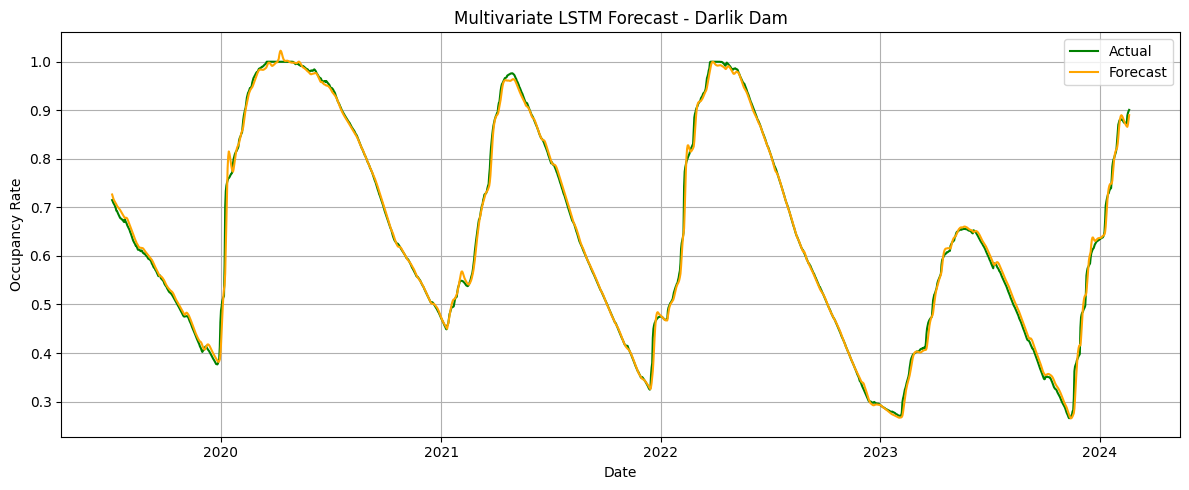

Model and scaler saved for Darlik

Training Multivariate LSTM for: Elmali


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Elmali - Multivariate LSTM MAE: 0.01 | RMSE: 0.02


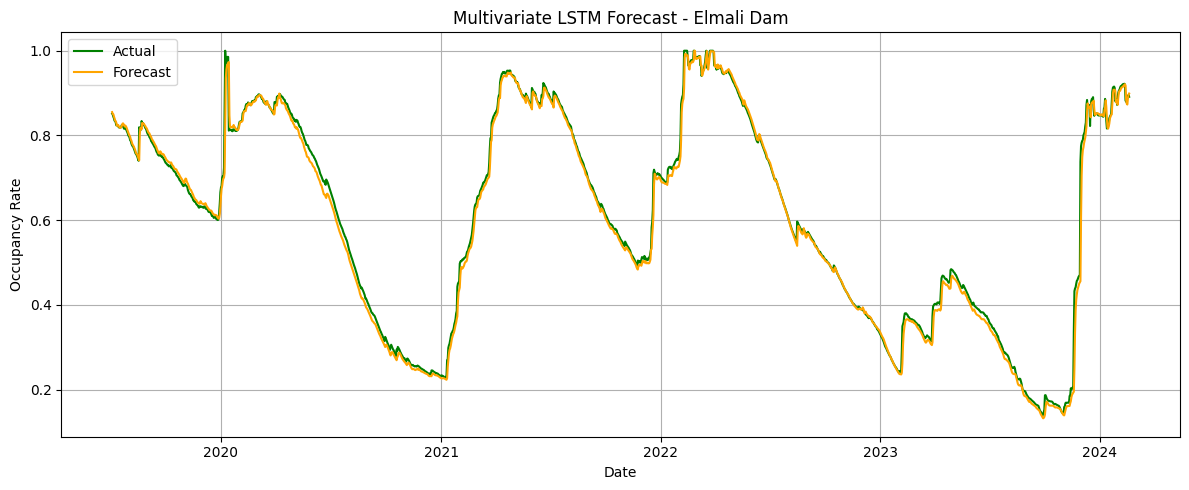

Model and scaler saved for Elmali

Training Multivariate LSTM for: Terkos


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Terkos - Multivariate LSTM MAE: 0.02 | RMSE: 0.02


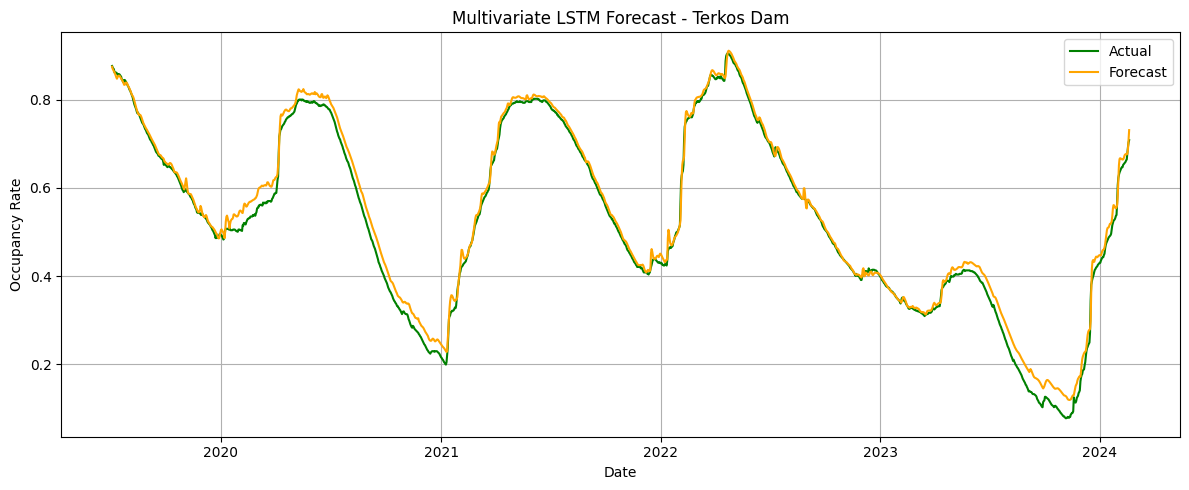

Model and scaler saved for Terkos

Training Multivariate LSTM for: Alibey


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Alibey - Multivariate LSTM MAE: 0.01 | RMSE: 0.01


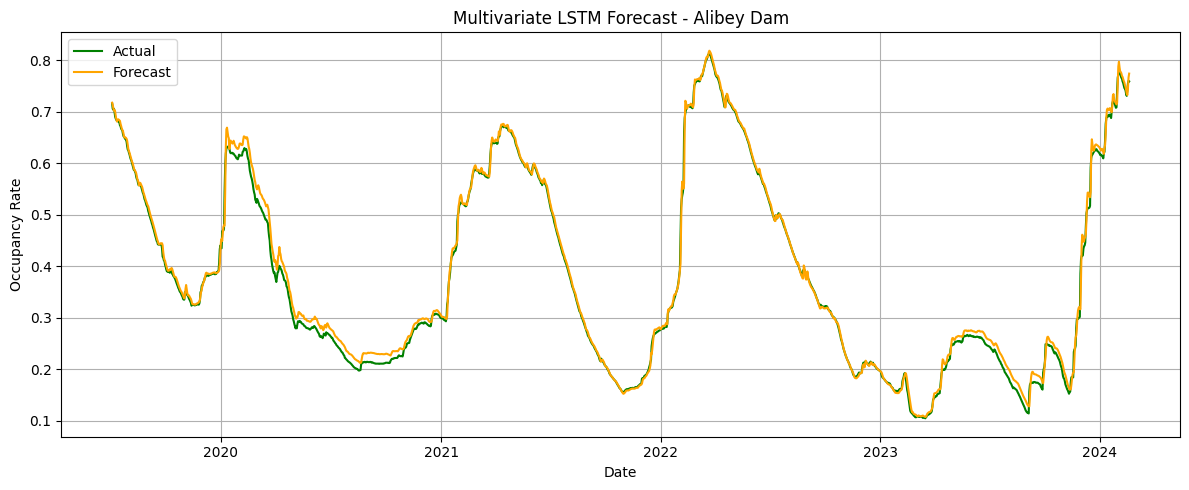

Model and scaler saved for Alibey

Training Multivariate LSTM for: Buyukcekmece


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Buyukcekmece - Multivariate LSTM MAE: 0.01 | RMSE: 0.02


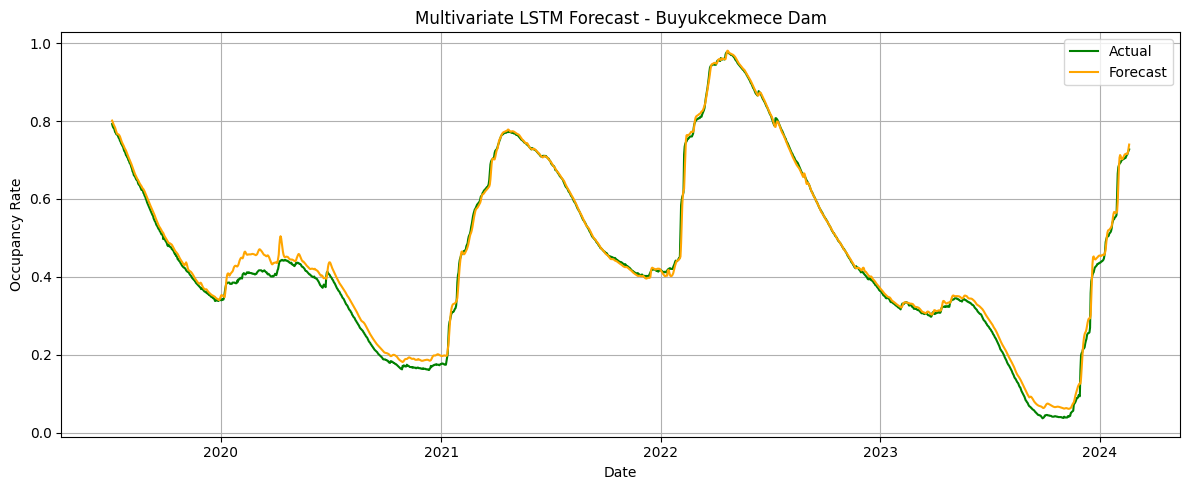

Model and scaler saved for Buyukcekmece

Training Multivariate LSTM for: Sazlidere


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Sazlidere - Multivariate LSTM MAE: 0.01 | RMSE: 0.01


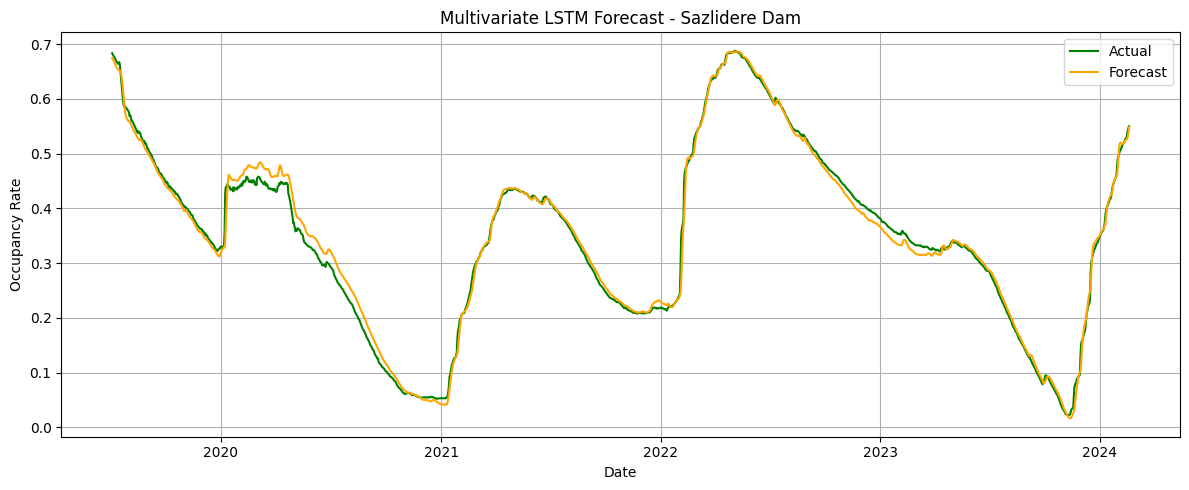

Model and scaler saved for Sazlidere

Training Multivariate LSTM for: Kazandere


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Kazandere - Multivariate LSTM MAE: 0.01 | RMSE: 0.02


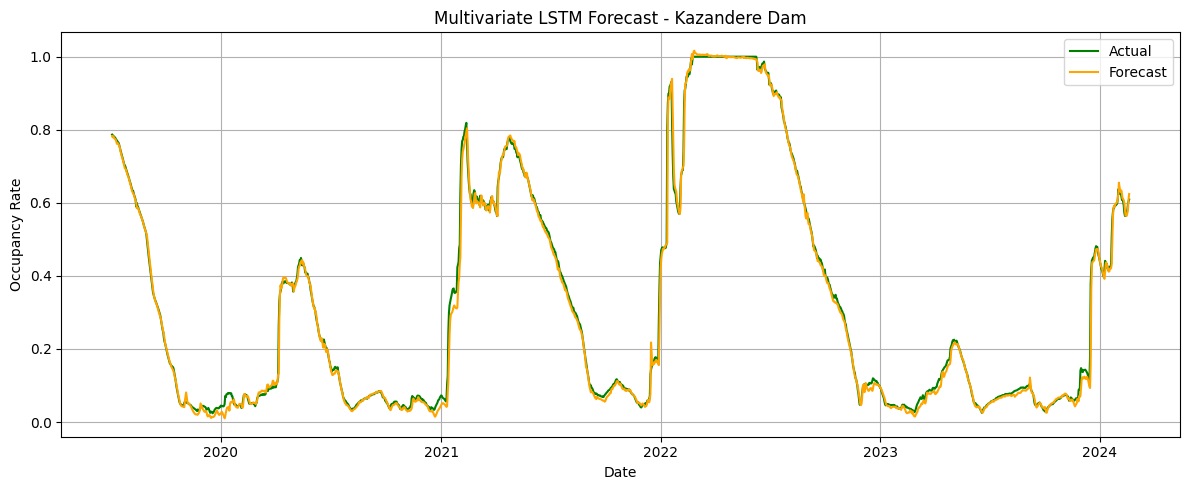

Model and scaler saved for Kazandere

Training Multivariate LSTM for: Pabucdere


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Pabucdere - Multivariate LSTM MAE: 0.01 | RMSE: 0.01


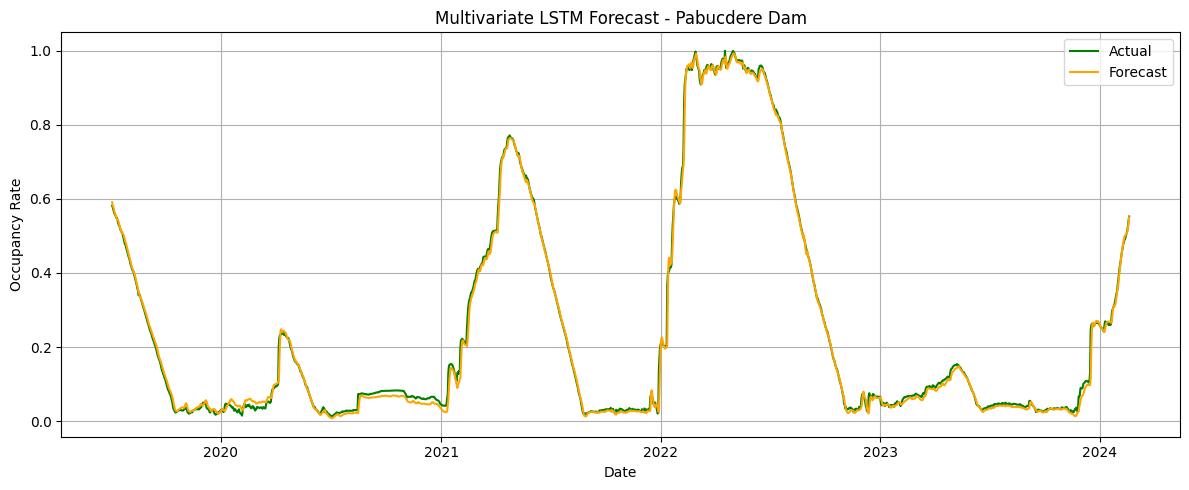

Model and scaler saved for Pabucdere

Training Multivariate LSTM for: Istrancalar


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Istrancalar - Multivariate LSTM MAE: 0.02 | RMSE: 0.04


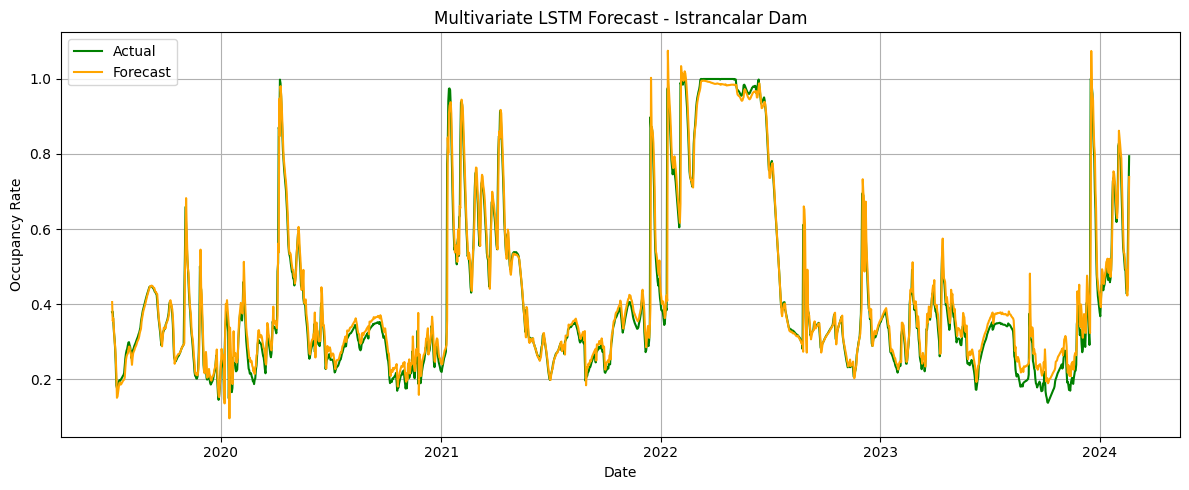

Model and scaler saved for Istrancalar


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping eklendi
import os
import joblib

# Creating output directories
os.makedirs("../models/multivariate_models_only_occupancy/lstm_multivariate", exist_ok=True)
os.makedirs("../models/multivariate_models_only_occupancy/lstm_multivariate/scalers", exist_ok=True)

# Loading cleaned dam-specific dataset
df = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df['Tarih'] = pd.to_datetime(df['Tarih'])

dam_columns = df.columns.drop('Tarih')

# Scaling all features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[dam_columns])
joblib.dump(scaler_X, "../models/multivariate_models_only_occupancy/lstm_multivariate/scalers/scaler_X.pkl")

# Saving dates
dates = df['Tarih'].reset_index(drop=True)

# Sequence creation function
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

# Looping through each dam
for dam in dam_columns:
    print(f"\nTraining Multivariate LSTM for: {dam}")

    # Output (y) column
    y = df[[dam]]
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)
    joblib.dump(scaler_y, f"../models/multivariate_models_only_occupancy/lstm_multivariate/scalers/scaler_y_{dam.lower()}.pkl")

    # Create sequences
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps=60)
    date_seq = dates[60:].reset_index(drop=True)

    # Train/val/test split
    train_size = int(len(X_seq) * 0.7)
    val_size = int(len(X_seq) * 0.1)

    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
    X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
    date_test = date_seq[train_size + val_size:]

    # Building the model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # EarlyStopping callback'ini tanımla
    # 'val_loss' monitör edilecek metrik, 'patience' kaç epoch sabır gösterileceği
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Training the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=30, batch_size=32, verbose=0,
                        callbacks=[early_stopping]) # callback'i ekle

    # Predicting
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    # Evaluation
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f"{dam} - Multivariate LSTM MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(date_test, y_test_inv, label="Actual", color="green")
    plt.plot(date_test, y_pred_inv, label="Forecast", color="orange")
    plt.title(f"Multivariate LSTM Forecast - {dam} Dam")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save model and scaler
    model.save(f"../models/multivariate_models_only_occupancy/lstm_multivariate/lstm_multi_{dam.lower()}.h5")
    print(f"Model and scaler saved for {dam}")